# ADS Thesis Project - Data Manipulation

**Authors: Daan Molenaar & Marion Späth (2772981)**


This notebook documents the data manipulation process.

Variables are grouped by topic, then renamed and processed before being merged together and transformed into wide format.


# Import libraries and Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from scipy.stats import f_oneway

In [99]:
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data')

df = pd.read_excel("all_y_p_v2.xlsx")
df.head()

,hhid_r4,id,buy_nr_cattle_r4,buy_cattle_r4,buy_nr_goat_r4,buy_goat_r4,n_previd_cattle_r4,n_previd_goat_r4,cs_cs_diff_post_cattle_r4,cs_cs_ratio_post_cattle_r4,...,s19q16_r2,s1913_2_r2,hhid,eng_language,amh_language,afm_language,agric_land,irrigated_land,expend,risky
0,1012410003,1,0,Not buy,0,Not buy,2,10,-188.170624,0.0,...,Yes,NaN,1.012410e+09,No,No,No,Yes,2.0,0.0,70.0
1,1012420005,2,0,Not buy,0,Not buy,2,10,-850.367249,0.0,...,Yes,NaN,1.012420e+09,No,No,Yes,Yes,0.0,0.0,20.0
2,1012420006,3,0,Not buy,0,Not buy,10,15,-5219.686523,0.0,...,Yes,NaN,1.012420e+09,No,No,Yes,No,NaN,1.0,22.0
3,1012420008,4,0,Not buy,0,Not buy,2,5,-157.544266,0.0,...,Yes,NaN,1.012420e+09,No,No,No,Yes,0.0,0.0,33.0
4,1012420021,5,0,Not buy,0,Not buy,0,12,NaN,NaN,...,Yes,NaN,1.012420e+09,No,No,No,Yes,2.0,1.0,34.0


# Some custom functions

In [100]:
def check_distributions(df):
    """ 
    Function takes a dataframe and prints frequencies per category if variable categorical and Min, Max, Mean, Std. if variable is numeric. 
    Prints number of missing values for each variable
    """
    for var in df.columns:
        print("Variable:", var)
        if df[var].dtype == 'object':
            print(f"\nValue counts for '{var}':")
            print(df[var].value_counts(dropna=False))
            print("Number of Missing Values:", df[var].isna().sum())

        else: 
            print("Min:", df[var].min())
            print("Max:", df[var].max())
            print("Mean:", df[var].dropna().mean())
            print("Std:", df[var].dropna().std())
            print("Number of Missing Values:", df[var].isna().sum())
        print("\n")

# Exploratory Analysis of Outcome

The Ratio Outcome seems to have very little variation and most people are exactly at 0. This will be investigated later on.

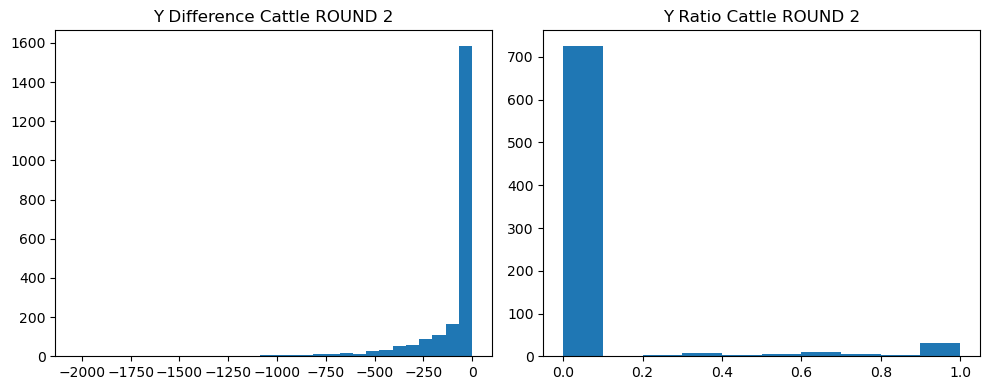

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(df.cs_cs_diff_post_cattle_r2, bins=30, range=[df['cs_cs_diff_post_cattle_r2'].min(), 0])
axes[0].set_title("Y Difference Cattle ROUND 2")

axes[1].hist(df.cs_cs_ratio_post_cattle_r2, bins=10, range=[0, 1])
axes[1].set_title("Y Ratio Cattle ROUND 2")
plt.tight_layout()

# Age Variables

The exploratory analyses below show inconsistent response bahaviour for many individuals. For example, some individuals' ages across two waves (which are 6 months apart) change by >20 years. Only a small minority changes their age in a plausible way. Considering those inconsistencies and given the overall short timeframe of datacollection of 1.5 years (3waves * 6months intervals), we decided to create an age variable that is time-invariable and contains only the first age an individual ever indicated. Note that only if an individuals age is missing in the first (or fist and second wave), we consider the age indicated in the second (or third) wave.

In [102]:
# Select age-related variables and rename them appropriately
age_vars = df[["id","s3_q7_r2", "s3_q7_0_r2", "s3_q7_1_r2", "s3_q7_r3", "s3_q7_0_r3", "s3_q7_1_r3", "s3_q7_r4", "s3_q7_0_r4", "s3_q7_1_r4" ]]
age_vars = age_vars.rename(columns={'s3_q7_r2': 'recorded_age_r2', 's3_q7_0_r2': 'recorded_age_correct_r2', 's3_q7_1_r2': 'age_updated_r2',
                                    's3_q7_r3': 'recorded_age_r3', 's3_q7_0_r3': 'recorded_age_correct_r3', 's3_q7_1_r3': 'age_updated_r3',
                                    's3_q7_r4': 'recorded_age_r4', 's3_q7_0_r4': 'recorded_age_correct_r4', 's3_q7_1_r4': 'age_updated_r4'})
age_vars.head()

,id,recorded_age_r2,recorded_age_correct_r2,age_updated_r2,recorded_age_r3,recorded_age_correct_r3,age_updated_r3,recorded_age_r4,recorded_age_correct_r4,age_updated_r4
0,1,25.0,No,36.0,36,Yes,NaN,36,Yes,NaN
1,2,27.0,No,47.0,47,Yes,NaN,47,Yes,NaN
2,3,29.0,Yes,NaN,29,Yes,NaN,29,Yes,NaN
3,4,35.0,Yes,NaN,35,Yes,NaN,35,Yes,NaN
4,5,36.0,Yes,NaN,36,Yes,NaN,36,Yes,NaN


In [103]:
# Denote missing and implausible (e.g., 999 or 560) values
numeric_cols = age_vars.select_dtypes(include='number').columns.drop('id')
age_vars[numeric_cols] = age_vars[numeric_cols].mask(
    (age_vars[numeric_cols] <= -99) | (age_vars[numeric_cols] > 99),
    np.nan)

In [104]:
# check how many individuals (dont) change their age across waves
age_vars['age_changes'] = age_vars.apply(lambda row: row['recorded_age_r2'] if 
                                          pd.notna(row['recorded_age_r2']) and 
                                          row['recorded_age_correct_r3'] == 'Yes' and 
                                          row['recorded_age_correct_r4'] == 'Yes' and
                                          row['recorded_age_correct_r2'] == 'Yes' else # row['age_updated_r2'] if pd.notna(row['age_updated_r2']) and (row['recorded_age_correct_r3']=='Yes') and  (row['recorded_age_correct_r4']=='Yes') else
                                          np.nan,
    axis=1
)
age_vars
age_vars.age_changes.isna().value_counts() # One third changes their age


age_changes
False    1619
True      797
Name: count, dtype: int64

In [105]:
# create time-invariable age variable as explained above (only first ever indicated age is saved)
age_vars['age_constant'] = age_vars.apply(lambda row: row['recorded_age_r2'] if 
                                          pd.notna(row['recorded_age_r2']) else row['age_updated_r2'] if
                                          pd.notna(row['age_updated_r2']) else row['age_updated_r3'] if
                                          pd.notna(row['age_updated_r3']) else row['age_updated_r4'], axis=1 )
age_vars.head()

,id,recorded_age_r2,recorded_age_correct_r2,age_updated_r2,recorded_age_r3,recorded_age_correct_r3,age_updated_r3,recorded_age_r4,recorded_age_correct_r4,age_updated_r4,age_changes,age_constant
0,1,25.0,No,36.0,36.0,Yes,NaN,36.0,Yes,NaN,NaN,25.0
1,2,27.0,No,47.0,47.0,Yes,NaN,47.0,Yes,NaN,NaN,27.0
2,3,29.0,Yes,NaN,29.0,Yes,NaN,29.0,Yes,NaN,29.0,29.0
3,4,35.0,Yes,NaN,35.0,Yes,NaN,35.0,Yes,NaN,35.0,35.0
4,5,36.0,Yes,NaN,36.0,Yes,NaN,36.0,Yes,NaN,36.0,36.0


In [106]:
# check number of missing values of new variable
age_vars['age_constant'].isna().sum()

22

In [107]:
# to check how many change their age in a plausible way +1 /+2 depending on data collection (0 = Implausible / 1= Plausible) --> not many
age_vars['test'] = np.where(
    (age_vars['age_constant'].notna()) & 
    (age_vars['recorded_age_r4'].notna()) & 
    (age_vars['age_constant'] == (age_vars['recorded_age_r4'] -1)),
    1,
    0)
age_vars.test.value_counts()

test
0    2348
1      68
Name: count, dtype: int64

Text(0.5, 1.0, 'age_constant')

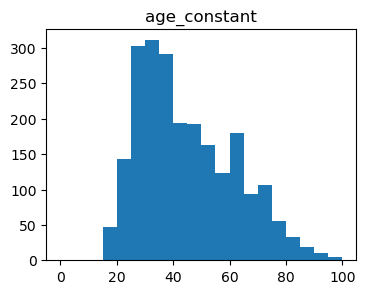

In [108]:
# Check distribution of new age variable
plt.figure(figsize=(4,3))
plt.hist(age_vars.recorded_age_r2, bins=20, range=(0,100))
plt.title("age_constant")

## Children Variables

Below, after inspecting the variables below, we noticed that the categories of 'activity_child_rX' and 'reason_not_in_school_child_rX' are very similar and therefore contain redundant information. We choose to drop 'reason_not_in_school_child_rX' and keep 'activity_child_rX' as the latter variable correctly classifies students which are marked as missing in the 'reason_not_in_school_child_rX' variable.
Further, we recode the variable containing the child's highest education (educ_child_rX) and their main activity (activity_child_rX) into broader categories for two reasons: 1. Low frequency counts of some categories, and 2. reduce the overall number of categories to increase model sparsity and reduce model inflation in later stages of the project.

In [109]:
# select variables related to children and rename them
children_vars = df[["id", "s5q7_r4", "s5_q7_5_n1_r4", "s5_q7_9_n1_r4", "s5_q8_3_n1_r4", "s5q7_r3", "s5_q7_5_n1_r3", "s5_q7_9_n1_r3", "s5_q8_3_n1_r3", "s5q7_r2", "s5_q7_5_n1_r2", "s5_q7_9_n1_r2", "s5_q8_3_n1_r2"]]
children_vars = children_vars.rename(columns={"s5q7_r4": "number_minors_r4",
                                              "s5_q7_5_n1_r4": "educ_child_r4",
                                              "s5_q7_9_n1_r4": "reason_not_in_school_child_r4",
                                              "s5_q8_3_n1_r4": "activity_child_r4",
                                              "s5q7_r3": "number_minors_r3", 
                                              "s5_q7_5_n1_r3": "educ_child_r3", 
                                              "s5_q7_9_n1_r3" : "reason_not_in_school_child_r3", 
                                              "s5_q8_3_n1_r3": "activity_child_r3", 
                                              "s5q7_r2": "number_minors_r2", 
                                              "s5_q7_5_n1_r2": "educ_child_r2", 
                                              "s5_q7_9_n1_r2": "reason_not_in_school_child_r2", 
                                              "s5_q8_3_n1_r2": "activity_child_r2"})
children_vars.head()

,id,number_minors_r4,educ_child_r4,reason_not_in_school_child_r4,activity_child_r4,number_minors_r3,educ_child_r3,reason_not_in_school_child_r3,activity_child_r3,number_minors_r2,educ_child_r2,reason_not_in_school_child_r2,activity_child_r2
0,1,2,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock,3,Never attended school,Too young,Not working: too young,2,Grade 3,NaN,Student
1,2,2,Never attended school,Too young,Not working: too young,5,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock,3,Grade 2,NaN,Student
2,3,2,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock,3,Never attended school,"Domestic duties (e.g. cooking, taking care of ...","Livestock production e.g. milking, sale of liv...",4,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock
3,4,3,Grade 6,NaN,Student,3,Never attended school,Too young,Not working: too young,6,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock
4,5,3,Never attended school,"Domestic duties (e.g. cooking, taking care of ...",Herding household-owned livestock,5,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock,5,Never attended school,Working for household own production (e.g.herding,Herding household-owned livestock


In [110]:
# drop reason_not_in_school_child_rX variable as explained above
children_vars = children_vars.drop(columns=["reason_not_in_school_child_r4", "reason_not_in_school_child_r3", "reason_not_in_school_child_r2"])

In [111]:
# check distribution of variables
check_distributions(children_vars)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: number_minors_r4
Min: 0
Max: 8
Mean: 2.806291390728477
Std: 1.4396549464179555
Number of Missing Values: 0


Variable: educ_child_r4

Value counts for 'educ_child_r4':
educ_child_r4
Never attended school                1052
Grade 2                               190
Grade 3                               158
Grade 4                               155
Grade 5                               147
Grade 6                               130
Grade 1                               116
Grade 7                               108
Grade 8                                95
NaN                                    83
Secondary 9                            56
Secondary 10                           32
Preparatory 11                         23
Preparatory 12                         17
Alternative Basic Education (ABE)      15
Nursery                                14
Adult Education                        1

Below we recode the variable into broader categores for reasons explained above.

In [142]:
# Define the recoding map
recode_map = {
    "Never attended school": "Never attended school",
    "Nursery": "Elementary",
    "Grade 1": "Elementary",
    "Grade 2": "Elementary",
    "Grade 3": "Elementary",
    "Grade 4": "Elementary",
    "Grade 5": "Elementary", 
    "Grade 6": "Elementary", 
    "Grade 7": "Elementary",
    "Grade 8": "Elementary", 
    "Secondary 9": "Secondary",
    "Secondary 10": "Secondary",
    "Preparatory 11": "Secondary",
    "Preparatory 12": "Secondary",
    "Alternative Basic Education (ABE)": "Other", # before diploma
    "Adult Education": "Other",
    "Diploma": "Secondary", # high school
    "Degree": "Other",
    "Postgraduate": "Other",
    "Other, specify": "Other",
    "Technical education" : "Other",
    "Certificate level teachers": "Other"
    }

# Define the recoding map
recode_map_num = {
    "Never attended school": 0,
    "Nursery": 1,
    "Grade 1": 2,
    "Grade 2": 3,
    "Grade 3": 4,
    "Grade 4": 5,
    "Grade 5": 6, 
    "Grade 6": 7, 
    "Grade 7": 8,
    "Grade 8": 9, 
    "Secondary 9": 10,
    "Secondary 10": 11,
    "Preparatory 11": 13,
    "Preparatory 12": 14,
    "Alternative Basic Education (ABE)": 15, # before diploma
    "Adult Education": 16,
    "Diploma": 12, # high school
    "Degree": 20,
    "Postgraduate": 21,
    "Other, specify": 17,
    "Technical education" : 18,
    "Certificate level teachers": 19 
    }


# List of columns to recode
columns_to_recode = ['educ_child_r2', 'educ_child_r3', 'educ_child_r4']

# apply recoding
for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    children_vars[new_col] = children_vars[col].map(recode_map)

for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recodedNUMERIC_{suffix}'  # insert 'recoded' in the middle
    children_vars[new_col] = children_vars[col].map(recode_map_num)

children_vars.head(2)

,id,number_minors_r4,educ_child_r4,activity_child_r4,number_minors_r3,educ_child_r3,activity_child_r3,number_minors_r2,educ_child_r2,activity_child_r2,...,educ_child_recoded_r4,educ_child_recoded_r2_num,educ_child_recoded_r3_num,educ_child_recoded_r4_num,activity_child_recoded_r2,activity_child_recoded_r3,activity_child_recoded_r4,educ_child_recodedNUMERIC_r2,educ_child_recodedNUMERIC_r3,educ_child_recodedNUMERIC_r4
0,1,2,Never attended school,Herding household-owned livestock,3,Never attended school,Not working: too young,2,Grade 3,Student,...,Never attended school,4.0,0.0,0.0,Student,Not working,Working with Livestock,4.0,0.0,0.0
1,2,2,Never attended school,Not working: too young,5,Never attended school,Herding household-owned livestock,3,Grade 2,Student,...,Never attended school,3.0,0.0,0.0,Student,Working with Livestock,Not working,3.0,0.0,0.0


In [185]:
# check distribution of new, recoded variable
children_vars.educ_child_recoded_r4.value_counts()

educ_child_recoded_r4
Elementary               1113
Never attended school    1052
Secondary                 132
Other                      36
Name: count, dtype: int64

Below we recode the variable into broader categores for reasons explained above.

In [ ]:
# Define the recoding map
recode_map_activity = {
    "Student": "Student",
    "Not working: too young": "Not working",
    "Looking for job": "Not working", # Not working
    "Not working: unable": "Not working",
    "Not working: too old": "Not working",

    "Herding household-owned livestock"                            : "Working with Livestock",
    "Livestock production e.g. milking, sale of livestock products": "Working with Livestock",

    "House/domestic work"                   : "House/domestic work",
    "Unpaid work in family's shop/business" : "House/domestic work", # this only happens ONCE in ONE Wave

    "Petty trading e.g charcoal/water trading": "Working",
    "Casual labor e.g. herding for pay": "Working",
    "Livestock trading/broker": "Working",
    "Shop/business owner": "Working",
    "Wage/salaried employment": "Working",
    "Mining": "Working",
    "Farming non-livestock" : "Working", # working
    "Other, specify" : "Working" # working or not working 
}

 # List of columns to recode
columns_to_recode = ['activity_child_r2', 'activity_child_r3', 'activity_child_r4']

# apply recoding
for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    children_vars[new_col] = children_vars[col].map(recode_map_activity)

children_vars.head(2)                                                                                            

,id,number_minors_r4,educ_child_r4,activity_child_r4,number_minors_r3,educ_child_r3,activity_child_r3,number_minors_r2,educ_child_r2,activity_child_r2,educ_child_recoded_r2,educ_child_recoded_r3,educ_child_recoded_r4,educ_child_recoded_r2_num,educ_child_recoded_r3_num,educ_child_recoded_r4_num,activity_child_recoded_r2,activity_child_recoded_r3,activity_child_recoded_r4
0,1,2,Never attended school,Herding household-owned livestock,3,Never attended school,Not working: too young,2,Grade 3,Student,Elementary,Never attended school,Never attended school,4.0,0.0,0.0,Student,Not working,Working with Livestock
1,2,2,Never attended school,Not working: too young,5,Never attended school,Herding household-owned livestock,3,Grade 2,Student,Elementary,Never attended school,Never attended school,3.0,0.0,0.0,Student,Working with Livestock,Not working


In [19]:
# check distribution for recoded variables
children_vars.activity_child_recoded_r3.value_counts() # replace rX with 2 or 3 to see the other waves, though they are similar

activity_child_recoded_r3
Student                   1261
Working with Livestock     557
Not working                387
House/domestic work        123
Working                     26
Name: count, dtype: int64

In [20]:
children_vars.activity_child_recoded_r2.isna().sum()

52

# Education Variables

After the initial inspection, the adult education variable showed strong inconsistencies in response behavior and data collection over time. For example, both the encoding of the variable and the type of education reported by respondents changed in implausible ways across waves. In the first two waves, the variable was encoded using character strings to represent nominal categories. In the last wave, however, it was numerically encoded with a much narrower range (e.g., previously there were more than 12 categories, while the numeric version only ranges from 1 to 3) and without any documentation explaining the change. Even within the first two waves, respondents often changed their answers drastically, frequently reporting lower rather than higher levels of education over time.

Due to these inconsistencies, we decided to treat adult education similarly to the age variable mentioned above—that is, as time-invariant. We created a new variable that records each individual's first-ever reported education. This decision is further justified by the short timeframe of the data collection.

Lastly, we recode the variable into broader categories to handle low frequency counts and to prevent model inflation later on. 

In [21]:
# selecr adult education variables and rename them
educ_vars = df[["id", "s3_q8_r2", "s3_q8_0_r2", "s3_q8_1_r2", "s3_q8_r3", "s3_q8_0_r3", "s3_q8_1_r3" , "s3_q8_r4", "s3_q8_0_r4", "s3_q8_1_r4"]] #s3_q8_1oth_r4
educ_vars = educ_vars.rename(columns={"s3_q8_r2" : "highest_educ_r2", "s3_q8_0_r2" : "highest_educ_correct_r2", "s3_q8_1_r2" : "highest_educ_updated_r2", 
                                      "s3_q8_r3" : "highest_educ_r3", "s3_q8_0_r3" : "highest_educ_correct_r3", "s3_q8_1_r3" : "highest_educ_updated_r3" ,
                                      "s3_q8_r4" : "highest_educ_r4", "s3_q8_0_r4" : "highest_educ_correct_r4", "s3_q8_1_r4" : "highest_educ_updated_r4"})

In [22]:
# check distributions
check_distributions(educ_vars)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: highest_educ_r2

Value counts for 'highest_educ_r2':
highest_educ_r2
Never attended school        1654
Nursery                       259
Adult Education                73
Grade 3                        50
Grade 4                        49
Grade 6                        43
Grade 2                        43
Grade 5                        41
Grade 8                        36
Alternative Basic Educati      34
Secondary 10                   30
Grade 7                        27
Secondary 9                    26
Grade 1                        16
Preparatory 12                  7
Diploma                         7
Preparatory 11                  7
NaN                             7
Degree                          5
Postgraduate                    1
Technical education             1
Name: count, dtype: int64
Number of Missing Values: 7


Variable: highest_educ_correct_r2

Value counts for 'hi

In [23]:
# some exploratory checks to investigate consistencies, data issues
    # here we can see how responses change if individuals indicated that their recorded education is wrong. We see that often the changes are implausible
educ_vars.highest_educ_correct_r2.value_counts()
test = educ_vars[educ_vars['highest_educ_correct_r3']== 'No']
test.head(15)

,id,highest_educ_r2,highest_educ_correct_r2,highest_educ_updated_r2,highest_educ_r3,highest_educ_correct_r3,highest_educ_updated_r3,highest_educ_r4,highest_educ_correct_r4,highest_educ_updated_r4
11,12,Never attended school,Yes,NaN,Never attended school,No,Grade 6,1,Yes,NaN
31,32,Never attended school,Yes,NaN,Never attended school,No,Secondary 9,2,Yes,NaN
38,39,Grade 6,Yes,NaN,Grade 6,No,Never attended school,2,No,Never attended school
186,187,Never attended school,Yes,NaN,Never attended school,No,Grade 8,3,Yes,NaN
244,245,Grade 7,Yes,NaN,Grade 7,No,Never attended school,3,Yes,NaN
247,248,Nursery,Yes,NaN,Nursery,No,Never attended school,3,Yes,NaN
252,253,Nursery,Yes,NaN,Nursery,No,Never attended school,1,Yes,NaN
282,283,Nursery,Yes,NaN,Nursery,No,Never attended school,3,Yes,NaN
287,288,Nursery,Yes,NaN,Nursery,No,Secondary 10,1,Yes,NaN
289,290,Alternative Basic Educati,Yes,NaN,NaN,No,Grade 7,2,Yes,NaN


In [24]:
# rename variable similar to age above, make it time-invariant, record only the first indicated education level
educ_vars['educ_constant'] = educ_vars.apply(lambda row: row['highest_educ_r2'] if 
                                          pd.notna(row['highest_educ_r2']) else row['highest_educ_updated_r2'] if
                                          pd.notna(row['highest_educ_updated_r2']) else row['highest_educ_updated_r3'] if
                                          pd.notna(row['highest_educ_updated_r3']) else row['highest_educ_updated_r4'], axis=1 )
educ_vars.head(2)

,id,highest_educ_r2,highest_educ_correct_r2,highest_educ_updated_r2,highest_educ_r3,highest_educ_correct_r3,highest_educ_updated_r3,highest_educ_r4,highest_educ_correct_r4,highest_educ_updated_r4,educ_constant
0,1,Never attended school,Yes,NaN,Never attended school,Yes,NaN,3,Yes,NaN,Never attended school
1,2,Adult Education,Yes,NaN,Adult Education,Yes,NaN,3,Yes,NaN,Adult Education


Below we recode the variable into broader categores for reasons explained above.

In [118]:
recode_map_highest_educ = {
    "Never attended school": "Never attended",
    "Nursery": "Nursery",
    "Grade 1": "Elementary",
    "Grade 2": "Elementary",
    "Grade 3": "Elementary",
    "Grade 4": "Elementary",
    "Grade 5": "Elementary",
    "Grade 6": "Elementary",
    "Grade 7": "Elementary",
    "Grade 8": "Elementary",
    "Secondary 9": "Secondary and Higher", # higher concerns only 7 people 
    "Secondary 10": "Secondary and Higher",
    "Preparatory 11": "Secondary and Higher",
    "Preparatory 12": "Secondary and Higher",
    "Alternative Basic Educati": "Adult Education",  
    "Adult Education": "Adult Education",
    "Diploma": "Secondary and Higher",
    "Degree": "Secondary and Higher",
    "Postgraduate": "Secondary and Higher",
    "Technical education": "Secondary and Higher"
}

recode_map_highest_educ_num = {
    "Never attended school": 1,
    "Nursery": 2,
    "Grade 1": 3,
    "Grade 2": 4,
    "Grade 3": 5,
    "Grade 4": 6,
    "Grade 5": 7,
    "Grade 6": 8,
    "Grade 7": 9,
    "Grade 8": 10,
    "Secondary 9": 11, # higher concerns only 7 people 
    "Secondary 10": 12,
    "Preparatory 11":15,
    "Preparatory 12": 16,
    "Alternative Basic Educati": 14,  
    "Adult Education":17,
    "Diploma": 13,
    "Degree": 19,
    "Postgraduate": 20,
    "Technical education": 18 
}

 # List of columns to recode
columns_to_recode = ['educ_constant']

for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    educ_vars[new_col] = educ_vars[col].map(recode_map_highest_educ)


for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}_num'  # insert 'recoded' in the middle
    educ_vars[new_col] = educ_vars[col].map(recode_map_highest_educ_num)

educ_vars.head(2)                                                                                            

,id,highest_educ_r2,highest_educ_correct_r2,highest_educ_updated_r2,highest_educ_r3,highest_educ_correct_r3,highest_educ_updated_r3,highest_educ_r4,highest_educ_correct_r4,highest_educ_updated_r4,educ_constant,educ_recoded_constant,educ_recoded_constant_num
0,1,Never attended school,Yes,NaN,Never attended school,Yes,NaN,3,Yes,NaN,Never attended school,Never attended,1
1,2,Adult Education,Yes,NaN,Adult Education,Yes,NaN,3,Yes,NaN,Adult Education,Adult Education,17


In [119]:
# check distribution of new variable
educ_vars.educ_recoded_constant.value_counts()

educ_recoded_constant
Never attended          1661
Elementary               305
Nursery                  259
Adult Education          107
Secondary and Higher      84
Name: count, dtype: int64

# Household Variables

We find one implausible value and outlier for the number of adults in the household in wave 4. We set this value to missing and will later impute that households previous value. This makes sense logically and is justified by the short time frame of the data collection. Otherwise the variables' distribution and categories were inspected but no further preprocessing was needed.

In [120]:
# select household variables and rename them
household_var = df[["id", "s5_q3_r2", "s5q5_r2", "s5_q3_r3", "s5q5_r3", "s5_q3_r4", "s5q5_r4"]] #s5_q3oth_r2 never used, only missings in all waves, therefore not included
household_var = household_var.rename(columns={"s5_q3_r2" : "household_description_r2", "s5q5_r2" : "number_adults_r2", 
                                              "s5_q3_r3" : "household_description_r3", "s5q5_r3" : "number_adults_r3", 
                                              "s5_q3_r4" : "household_description_r4", "s5q5_r4" : "number_adults_r4"})

In [28]:
# check distributions
check_distributions(household_var)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: household_description_r2

Value counts for 'household_description_r2':
household_description_r2
Fully settled: The whole of the household (all members, including head) is permanently settled                                    2044
Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals     312
Not settled: The whole household moves around in order to herd the animals                                                          60
Name: count, dtype: int64
Number of Missing Values: 0


Variable: number_adults_r2
Min: 0
Max: 10
Mean: 2.3973509933774833
Std: 1.314443264580191
Number of Missing Values: 0


Variable: household_description_r3

Value counts for 'household_description_r3':
household_description_r3
Fully settled: The whole of the household (all members, including head) is permanently settled                 

(array([  83.,  282., 1340.,  341.,  189.,   95.,   50.,   20.,   12.,
          4.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), <BarContainer object of 10 artists>)
(array([4.450e+02, 1.212e+03, 3.340e+02, 3.200e+02, 6.500e+01, 1.800e+01,
       1.500e+01, 4.000e+00, 1.000e+00, 2.000e+00]), array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]), <BarContainer object of 10 artists>)


Text(0.5, 1.0, 'number_adults')

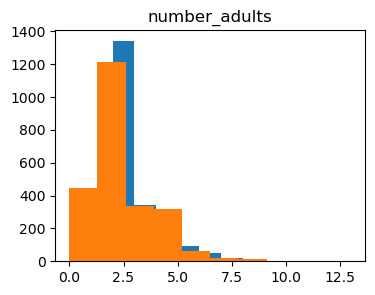

In [121]:
# visualise distributions
plt.figure(figsize=(4,3))
print(plt.hist(household_var.number_adults_r2))
print(plt.hist(household_var.number_adults_r3))
plt.title("number_adults")


(array([2.364e+03, 4.900e+01, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00]), array([ 0.        ,  4.33333333,  8.66666667, 13.        , 17.33333333,
       21.66666667, 26.        , 30.33333333, 34.66666667, 39.        ,
       43.33333333, 47.66666667, 52.        , 56.33333333, 60.66666667,
       65.        ]), <BarContainer object of 15 artists>)


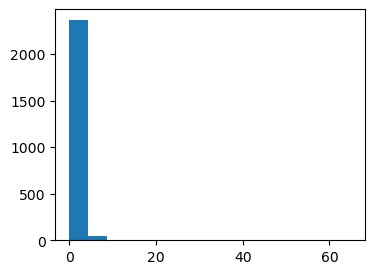

In [122]:
# check wave 4
plt.figure(figsize=(4,3))
print(plt.hist(household_var.number_adults_r4, range=[0,65], bins=15)) # One outlier -> set missing and impute that individuals previous value

In [123]:
# set oultier to missing, will be imputed later below when data is in long format
household_var['number_adults_r4'] = household_var['number_adults_r4'].mask( household_var['number_adults_r4'] == 65, np.nan)

# Information Variables

The variables record the main source of information the household with regard to the IBLI product. We recode the categories to account for some low frequency counts and to improve model sparsity later.

In [124]:
# select information variables and rename them
info_var = df[["id", "s17q3_r2", "s17q3_r3", "s17q3_r4"]]
info_var = info_var.rename(columns={"s17q3_r2": "main_info_source_r2", "s17q3_r3": "main_info_source_r3", "s17q3_r4": "main_info_source_r4"})
info_var

,id,main_info_source_r2,main_info_source_r3,main_info_source_r4
0,1,NaN,enumerators,enumerators
1,2,enumerators,enumerators,enumerators
2,3,NaN,survey conducted by ILRI,insurance extension staff (including VIPs/Insu...
3,4,"neighbors, friends and relatives in informal g...",community meetings,enumerators
4,5,enumerators,enumerators,enumerators
...,...,...,...,...
2411,2412,"neighbors, friends and relatives in informal g...",insurance extension staff (including VIPs/Insu...,insurance extension staff (including VIPs/Insu...
2412,2413,Oromia Insurance Company staff (OIC) excluding...,enumerators,enumerators
2413,2414,insurance extension staff (including VIPs/Insu...,survey conducted by ILRI,enumerators
2414,2415,Oromia Insurance Company staff (OIC) excluding...,Oromia Insurance Company staff (OIC) excluding...,enumerators


In [33]:
# check distributions
check_distributions(info_var)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: main_info_source_r2

Value counts for 'main_info_source_r2':
main_info_source_r2
NaN                                                                                                                               613
insurance extension staff (including VIPs/Insurance promoters)                                                                    527
enumerators                                                                                                                       443
community meetings                                                                                                                286
neighbors, friends and relatives in informal groups                                                                               233
Oromia Insurance Company staff (OIC) excluding VIPs/insurance promoters and/or Oromia Saving and Credits Share Company (WALQO)     83
survey co

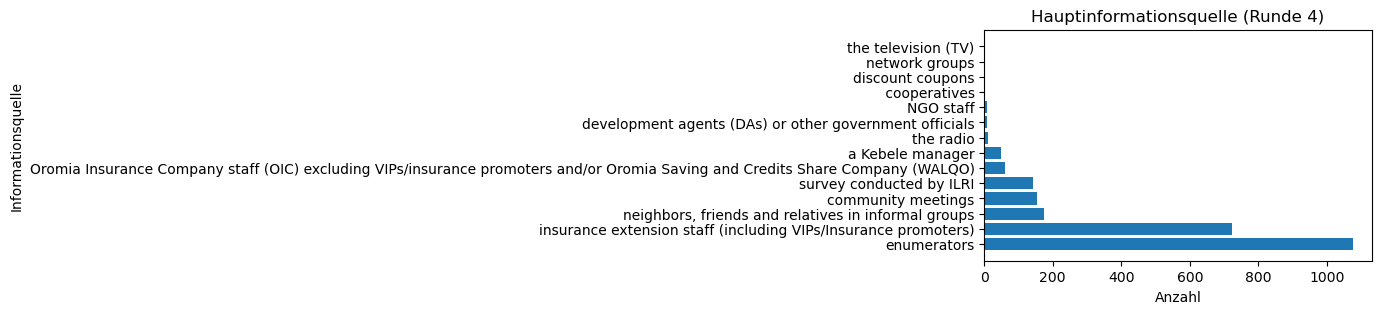

In [ ]:
# visualise distribution for one wave
counts = info_var['main_info_source_r3'].value_counts(dropna=False)

plt.figure(figsize=(5,3))
plt.barh(counts.index.astype(str), counts.values)
plt.xlabel("Anzahl")
plt.ylabel("Informationsquelle")
plt.title("Hauptinformationsquelle (Runde 4)")
plt.show()

Below we recode the variable into broader categores for reasons explained above.

In [125]:
recode_map_main_info_source = {
    "enumerators": "Interpersonal Sources",
    "a Kebele manager": "Interpersonal Sources",
    "neighbors, friends and relatives in informal groups": "Interpersonal Sources",
    "development agents (DAs) or other government officials": "Interpersonal Sources",
    "NGO staff": "Interpersonal Sources",

    "insurance extension staff (including VIPs/Insurance promoters)": "Professional and Organizational Sources",
    "Oromia Insurance Company staff (OIC) excluding VIPs/insurance promoters and/or Oromia Saving and Credits Share Company (WALQO)": "Professional and Organizational Sources",

    "network groups": "Media, Community-Based, and Survey Sources",
    "the radio": "Media, Community-Based, and Survey Sources",
    "community meetings": "Media, Community-Based, and Survey Sources",
    "survey conducted by ILRI": "Media, Community-Based, and Survey Sources",
    "posters": "Media, Community-Based, and Survey Sources",        
    " cooperatives": "Media, Community-Based, and Survey Sources",
    "discount coupons": "Media, Community-Based, and Survey Sources",
    "the television (TV)": "Media, Community-Based, and Survey Sources",
}

 # List of columns to recode
columns_to_recode = ['main_info_source_r2', 'main_info_source_r3', 'main_info_source_r4']

# apply mapping
for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    info_var[new_col] = info_var[col].map(recode_map_main_info_source)

info_var.head(5)                                                                                            

,id,main_info_source_r2,main_info_source_r3,main_info_source_r4,main_info_source_recoded_r2,main_info_source_recoded_r3,main_info_source_recoded_r4
0,1,NaN,enumerators,enumerators,NaN,Interpersonal Sources,Interpersonal Sources
1,2,enumerators,enumerators,enumerators,Interpersonal Sources,Interpersonal Sources,Interpersonal Sources
2,3,NaN,survey conducted by ILRI,insurance extension staff (including VIPs/Insu...,NaN,"Media, Community-Based, and Survey Sources",Professional and Organizational Sources
3,4,"neighbors, friends and relatives in informal g...",community meetings,enumerators,Interpersonal Sources,"Media, Community-Based, and Survey Sources",Interpersonal Sources
4,5,enumerators,enumerators,enumerators,Interpersonal Sources,Interpersonal Sources,Interpersonal Sources


In [126]:
# check distribution of new variable(s)
info_var.main_info_source_recoded_r4.value_counts()

main_info_source_recoded_r4
Interpersonal Sources                         1606
Professional and Organizational Sources        570
Media, Community-Based, and Survey Sources     240
Name: count, dtype: int64

# Insurance Variables

Initial inspection of the variables shows that both advise_vip_r2 and advise_vip_r3 are completely missing. We can either see this as indication that individuals probably did not get any advise and thus assign "No" to all individuals in those waves, or we can drop the variable. For now, we choose the first option, wait for Samin's feedback and might drop the variable easily later on.

Inspection also showed very high rates of missing values (around 66%) across all waves for the variable that records the relationship an individual had with their local VIP (relationship_vip_rX). As we still have a more reliable variable that records whether the individual knew their VIP, we decide to drop the relationship_vip_rX variables.

In [127]:
# select insurance variables and rename them
insurance_vars = df[["id", "s18q4_n1_r2", "s18q5_n1_r2", "s19q1_r2", "s19q9_r2", "s19q16_r2", "s1913_2_r2",
                           "s18q4_n1_r3", "s18q5_n1_r3", "s19q1_r3", "s19q9_r3", "s19q16_r3", "s1913_2_r3", 
                           "s18q4_n1_r4", "s18q5_n1_r4", "s19q1_r4", "s19q9_r4", "s19q16_r4", "s1913_2_r4"]]

insurance_vars = insurance_vars.rename(columns={"s18q4_n1_r2" : "purchase_bin_r2", "s18q5_n1_r2" : "why_not_purchase_r2", "s19q1_r2" : "know_vip_r2", "s19q9_r2" : "relationship_vip_r2", "s19q16_r2" : "trust_vip_r2", "s1913_2_r2" : "advise_vip_r2",
                                                "s18q4_n1_r3" : "purchase_bin_r3", "s18q5_n1_r3" : "why_not_purchase_r3", "s19q1_r3" : "know_vip_r3", "s19q9_r3" : "relationship_vip_r3", "s19q16_r3" : "trust_vip_r3", "s1913_2_r3" : "advise_vip_r3", 
                                                "s18q4_n1_r4" : "purchase_bin_r4", "s18q5_n1_r4" : "why_not_purchase_r4", "s19q1_r4" : "know_vip_r4", "s19q9_r4" : "relationship_vip_r4", "s19q16_r4" : "trust_vip_r4", "s1913_2_r4" : "advise_vip_r4"})
insurance_vars.head()

,id,purchase_bin_r2,why_not_purchase_r2,know_vip_r2,relationship_vip_r2,trust_vip_r2,advise_vip_r2,purchase_bin_r3,why_not_purchase_r3,know_vip_r3,relationship_vip_r3,trust_vip_r3,advise_vip_r3,purchase_bin_r4,why_not_purchase_r4,know_vip_r4,relationship_vip_r4,trust_vip_r4,advise_vip_r4
0,1,No,Did not understand insurance well enough,No,NaN,Yes,NaN,No,Did not understand insurance well enough,Yes,Close friend,Yes,NaN,No,Did not understand insurance well enough,Yes,NaN,Yes,Yes
1,2,No,Did not know who the agent was or could not fi...,No,NaN,Yes,NaN,No,Unaware/Have not heard that insurance was avai...,Yes,NaN,Yes,NaN,No,Did not have enough animals,Yes,NaN,Yes,Yes
2,3,No,Did not understand insurance well enough,Yes,NaN,Yes,NaN,No,Did not have enough animals,Yes,sub-clan member,No,NaN,No,Cost is too high,Yes,NaN,Yes,Yes
3,4,No,Did not understand insurance well enough,Yes,NaN,Yes,NaN,No,Did not understand coupon,Yes,NaN,Yes,NaN,No,Did not have enough animals,Yes,Other,Yes,Yes
4,5,No,Did not understand insurance well enough,Yes,NaN,Yes,NaN,No,Did not understand insurance well enough,Yes,NaN,Yes,NaN,No,Did not understand insurance well enough,Yes,NaN,Yes,Yes


Some missing values in why_not_purchase and relationship_vip can be filled logically. however, the problem with the large amount of missings remains for the latter.

In [128]:
# In some variables, a missing values is created due to the design of the questions and their filtering --> correct those missing values
insurance_vars["why_not_purchase_r2"] = np.where(insurance_vars['purchase_bin_r2']=="Yes", "BOUGHT INSURANCE", insurance_vars["why_not_purchase_r2"]) 
insurance_vars["why_not_purchase_r3"] = np.where(insurance_vars['purchase_bin_r3']=="Yes", "BOUGHT INSURANCE", insurance_vars["why_not_purchase_r3"])
insurance_vars["why_not_purchase_r4"] = np.where(insurance_vars['purchase_bin_r4']=="Yes", "BOUGHT INSURANCE", insurance_vars["why_not_purchase_r4"]) 

insurance_vars["relationship_vip_r2"] = np.where(insurance_vars['know_vip_r2']=="No", "DIDNT KNOW VIP", insurance_vars["relationship_vip_r2"]) 
insurance_vars["relationship_vip_r3"] = np.where(insurance_vars['know_vip_r3']=="No", "DIDNT KNOW VIP", insurance_vars["relationship_vip_r3"]) 
insurance_vars["relationship_vip_r4"] = np.where(insurance_vars['know_vip_r4']=="No", "DIDNT KNOW VIP", insurance_vars["relationship_vip_r4"]) 

insurance_vars["advise_vip_r2"] = 'No'
insurance_vars["advise_vip_r3"] = 'No'

In [129]:
# check distribution and for consistency, not the large number of missings for the relationship variable mentioned above
check_distributions(insurance_vars)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: purchase_bin_r2

Value counts for 'purchase_bin_r2':
purchase_bin_r2
No     2227
Yes     189
Name: count, dtype: int64
Number of Missing Values: 0


Variable: why_not_purchase_r2

Value counts for 'why_not_purchase_r2':
why_not_purchase_r2
Unaware/Have not heard that insurance was available           792
Did not understand insurance well enough                      504
Did not know who the agent was or could not find them         246
Did not have enough animals                                   206
BOUGHT INSURANCE                                              189
Too expensive/could not afford                                 82
Did not trust the insurance agent or company                   71
Waiting to see what happens to other people with insurance     64
Afraid of uncertainty in insurance                             62
Did not want product/product not good for me                

In [130]:
# drop reason_not_in_school_child_rX variable as explained above
insurance_vars = insurance_vars.drop(columns=["relationship_vip_r2", "relationship_vip_r3", "relationship_vip_r4"])

Below we recode the variable into broader categores for reasons explained above.

In [131]:
recode_map_why_not_purchase = {
    "BOUGHT INSURANCE": "BOUGHT INSURANCE",

    "Did not understand insurance well enough": "Lack of Awareness or Understanding",
    "Did not understand coupon": "Lack of Awareness or Understanding",
    "Unaware/Have not heard that insurance was available": "Lack of Awareness or Understanding",
    "Did not know who the agent was or could not find them": "Lack of Awareness or Understanding",

    "Afraid of uncertainty in insurance": "Distrust or Negative Perception",
    "Did not trust the insurance agent or company": "Distrust or Negative Perception",
    "Discouraged by someone in the community/family": "Distrust or Negative Perception",
    "Did not want product/product not good for me": "Distrust or Negative Perception",
    "Did not want product/product not good generally": "Distrust or Negative Perception",

    "Cost is too high": "Financial, Practical, and Situational Constraints",
    "Too expensive/could not afford": "Financial, Practical, and Situational Constraints",
    "Coupon got lost": "Financial, Practical, and Situational Constraints",
    "Can rely on family and friends": "Financial, Practical, and Situational Constraints",
    "Little/No risk of drought this year": "Financial, Practical, and Situational Constraints",
    "Other": "Financial, Practical, and Situational Constraints",
    "Too busy": "Financial, Practical, and Situational Constraints",
    "Waiting to see what happens to other people with insurance": "Financial, Practical, and Situational Constraints",
    "Had coverage from KLIP": "Financial, Practical, and Situational Constraints",
    "Could not because did not have ID and/or Mpesa account": "Financial, Practical, and Situational Constraints",
    "Did not have enough animals": "Financial, Practical, and Situational Constraints",

}

 # List of columns to recode
columns_to_recode = ['why_not_purchase_r2', 'why_not_purchase_r3', 'why_not_purchase_r4']

# apply mapping
for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    insurance_vars[new_col] = insurance_vars[col].map(recode_map_why_not_purchase)

insurance_vars.head(5)                                                                                            

,id,purchase_bin_r2,why_not_purchase_r2,know_vip_r2,trust_vip_r2,advise_vip_r2,purchase_bin_r3,why_not_purchase_r3,know_vip_r3,trust_vip_r3,advise_vip_r3,purchase_bin_r4,why_not_purchase_r4,know_vip_r4,trust_vip_r4,advise_vip_r4,why_not_purchase_recoded_r2,why_not_purchase_recoded_r3,why_not_purchase_recoded_r4
0,1,No,Did not understand insurance well enough,No,Yes,No,No,Did not understand insurance well enough,Yes,Yes,No,No,Did not understand insurance well enough,Yes,Yes,Yes,Lack of Awareness or Understanding,Lack of Awareness or Understanding,Lack of Awareness or Understanding
1,2,No,Did not know who the agent was or could not fi...,No,Yes,No,No,Unaware/Have not heard that insurance was avai...,Yes,Yes,No,No,Did not have enough animals,Yes,Yes,Yes,Lack of Awareness or Understanding,Lack of Awareness or Understanding,"Financial, Practical, and Situational Constraints"
2,3,No,Did not understand insurance well enough,Yes,Yes,No,No,Did not have enough animals,Yes,No,No,No,Cost is too high,Yes,Yes,Yes,Lack of Awareness or Understanding,"Financial, Practical, and Situational Constraints","Financial, Practical, and Situational Constraints"
3,4,No,Did not understand insurance well enough,Yes,Yes,No,No,Did not understand coupon,Yes,Yes,No,No,Did not have enough animals,Yes,Yes,Yes,Lack of Awareness or Understanding,Lack of Awareness or Understanding,"Financial, Practical, and Situational Constraints"
4,5,No,Did not understand insurance well enough,Yes,Yes,No,No,Did not understand insurance well enough,Yes,Yes,No,No,Did not understand insurance well enough,Yes,Yes,Yes,Lack of Awareness or Understanding,Lack of Awareness or Understanding,Lack of Awareness or Understanding


In [43]:
insurance_vars.why_not_purchase_recoded_r4.value_counts()

why_not_purchase_recoded_r4
Financial, Practical, and Situational Constraints    864
Lack of Awareness or Understanding                   778
BOUGHT INSURANCE                                     659
Distrust or Negative Perception                      114
Name: count, dtype: int64

# Move Variables 

Inspection of the variables showed no need for further preprocessing. The variable also has no missing values.

In [132]:
# select move variabes and rename them
move_vars = df[["id", "s5_q2_r2", "s5_q2_r3", "s5_q2_r4"]]
move_vars = move_vars.rename(columns={"s5_q2_r2": "household_moved_r2", "s5_q2_r3": "household_moved_r3", "s5_q2_r4": "household_moved_r4"})
check_distributions(move_vars)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: household_moved_r2

Value counts for 'household_moved_r2':
household_moved_r2
No     1966
Yes     450
Name: count, dtype: int64
Number of Missing Values: 0


Variable: household_moved_r3

Value counts for 'household_moved_r3':
household_moved_r3
No     2157
Yes     259
Name: count, dtype: int64
Number of Missing Values: 0


Variable: household_moved_r4

Value counts for 'household_moved_r4':
household_moved_r4
No     2280
Yes     136
Name: count, dtype: int64
Number of Missing Values: 0




# Phone Variables

We make sense of the data by creating one new variable per wave which indicates whether someone in the household owns a phone. This variable can be seen as a proxy measuring access to technology.

In [133]:
# select phone variables and rename them
phone_vars = df[["id", "s4_q1_r2", "s4_q1_0_r2", "s4_q1_1_r2", "s4_q2_r2", "s4_q2_1_r2", "s4_q3_r2", 
                 "s4_q1_r3", "s4_q1_0_r3", "s4_q1_1_r3", "s4_q2_r3", "s4_q2_1_r3", "s4_q3_r3",
                 "s4_q1_r4", "s4_q1_0_r4", "s4_q1_1_r4", "s4_q2_r4", "s4_q2_1_r4", "s4_q3_r4"]]
phone_vars = phone_vars.rename(columns={"s4_q1_r2" : "num_rec_r2", "s4_q1_0_r2" : "num_rec_correct_r2", "s4_q1_1_r2" : "best_contact_r2", "s4_q2_r2" : "no_phone_before_r2", "s4_q2_1_r2" : "if_yes_number_r2", "s4_q3_r2" : "phone_users_house_r2", 
                                        "s4_q1_r3" : "num_rec_r3", "s4_q1_0_r3" : "num_rec_correct_r3", "s4_q1_1_r3" : "best_contact_r3", "s4_q2_r3" : "no_phone_before_r3", "s4_q2_1_r3" : "if_yes_number_r3", "s4_q3_r3" : "phone_users_house_r3",
                                        "s4_q1_r4" : "num_rec_r4", "s4_q1_0_r4" : "num_rec_correct_r4", "s4_q1_1_r4" : "best_contact_r4", "s4_q2_r4" : "no_phone_before_r4", "s4_q2_1_r4" : "if_yes_number_r4", "s4_q3_r4" : "phone_users_house_r4"})
phone_vars.head()

,id,num_rec_r2,num_rec_correct_r2,best_contact_r2,no_phone_before_r2,if_yes_number_r2,phone_users_house_r2,num_rec_r3,num_rec_correct_r3,best_contact_r3,no_phone_before_r3,if_yes_number_r3,phone_users_house_r3,num_rec_r4,num_rec_correct_r4,best_contact_r4,no_phone_before_r4,if_yes_number_r4,phone_users_house_r4
0,1,NaN,Yes,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No
1,2,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,No
2,3,NaN,Yes,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No
3,4,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No
4,5,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN,NaN,No


In [134]:
# create new variable that records whether someone in the household owns a phone, time-variables --> one variable per wave
phone_vars['owns_phone_r2'] = np.where((phone_vars['num_rec_r2'].notna())|  (phone_vars['phone_users_house_r2']=='Yes') | (phone_vars['best_contact_r2'].notna() ), 1, 0)
phone_vars['owns_phone_r3'] = np.where((phone_vars['num_rec_r3'].notna()) | (phone_vars['phone_users_house_r3']=='Yes') | (phone_vars['best_contact_r3'].notna() ), 1, 0)
phone_vars['owns_phone_r4'] = np.where((phone_vars['num_rec_r4'].notna()) | (phone_vars['phone_users_house_r4']=='Yes') | (phone_vars['best_contact_r4'].notna() ), 1, 0)

# check distribution
phone_vars.owns_phone_r4.value_counts()

owns_phone_r4
0    1909
1     507
Name: count, dtype: int64

# Religion Variables

For each wave, we create a variable that records the households (updated) religion. Because of the frequency distribution and model sparsity later we recode the variable and group all Christian religions together.

Overall, the variable shows little change over time

In [135]:
# select religion variables and rename them
religion_vars = df[["id", "s5_q1_r2", "s5_q1_0_r2", "s5_q1_1_r2", "s5_q1_r3", "s5_q1_0_r3", "s5_q1_1_r3", "s5_q1_r4", "s5_q1_0_r4", "s5_q1_1_r4"]] # rec_rel_other_rX all missing, not used
religion_vars = religion_vars.rename(columns={"s5_q1_r2" : "rec_rel_r2", "s5_q1_0_r2" : "rec_rel_cor_r2", "s5_q1_1_r2" : "rec_rel_upd_r2", "s5_q1_1oth_r2": "rec_rel_other_r2",
                                              "s5_q1_r3" : "rec_rel_r3", "s5_q1_0_r3" : "rec_rel_cor_r3", "s5_q1_1_r3" : "rec_rel_upd_r3", "s5_q1_1oth_r3": "rec_rel_other_r3", 
                                              "s5_q1_r4" : "rec_rel_r4", "s5_q1_0_r4" : "rec_rel_cor_r4", "s5_q1_1_r4" : "rec_rel_upd_r4", "s5_q1_1oth_r4" : "rec_rel_other_r4"})
religion_vars.head()

,id,rec_rel_r2,rec_rel_cor_r2,rec_rel_upd_r2,rec_rel_r3,rec_rel_cor_r3,rec_rel_upd_r3,rec_rel_r4,rec_rel_cor_r4,rec_rel_upd_r4
0,1,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN
1,2,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN
2,3,Protestant,Yes,NaN,Protestant,Yes,NaN,Protestant,Yes,NaN
3,4,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN
4,5,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN


In [136]:
# create updated religion per wave and investigate how much change is happening
religion_vars['religion_r2'] = np.where((religion_vars['rec_rel_r2'].notna()) &  (religion_vars['rec_rel_cor_r2']=='Yes'), religion_vars["rec_rel_r2"], religion_vars["rec_rel_upd_r2"])
religion_vars['religion_r3'] = np.where((religion_vars['rec_rel_r3'].notna()) &  (religion_vars['rec_rel_cor_r3']=='Yes'), religion_vars["rec_rel_r3"], religion_vars["rec_rel_upd_r3"])
religion_vars['religion_r4'] = np.where((religion_vars['rec_rel_r4'].notna()) &  (religion_vars['rec_rel_cor_r4']=='Yes'), religion_vars["rec_rel_r4"], religion_vars["rec_rel_upd_r4"])

religion_vars['religion_change'] = np.where((religion_vars['religion_r2'] ==religion_vars['religion_r3']) & (religion_vars['religion_r3'] == religion_vars['religion_r4']), 0, 1)

religion_vars.head()
religion_vars.religion_change.value_counts()

religion_change
0    2328
1      88
Name: count, dtype: int64

In [137]:
# check distributions
check_distributions(religion_vars)

Variable: id
Min: 1
Max: 2416
Mean: 1208.5
Std: 697.5834478158629
Number of Missing Values: 0


Variable: rec_rel_r2

Value counts for 'rec_rel_r2':
rec_rel_r2
Traditional/Wakefata    1590
Muslim                   555
Protestant               235
Orthodox                  15
Catholic                  10
NaN                        7
Other Christian            4
Name: count, dtype: int64
Number of Missing Values: 7


Variable: rec_rel_cor_r2

Value counts for 'rec_rel_cor_r2':
rec_rel_cor_r2
Yes    2306
No      110
Name: count, dtype: int64
Number of Missing Values: 0


Variable: rec_rel_upd_r2

Value counts for 'rec_rel_upd_r2':
rec_rel_upd_r2
NaN                     2306
Traditional/Wakefata      61
Protestant                25
Muslim                    22
Other Christian            1
Orthodox                   1
Name: count, dtype: int64
Number of Missing Values: 2306


Variable: rec_rel_r3

Value counts for 'rec_rel_r3':
rec_rel_r3
Traditional/Wakefata    1590
Muslim                 

Below we recode the variable into broader categores for reasons explained above. Specifically, we group together the Christian sub-categories.

In [138]:
# Create mapping, essentially group all Christians together
recode_map_religion = {
    "Traditional/Wakefata" : "Traditional/Wakefata",
    "Muslim" : "Muslim",
    "Protestant" : "Christian",
    "Orthodox" : "Christian",
    "Catholic" : "Christian",
    "Other Christian" : "Christian"
}

 # List of columns to recode
columns_to_recode = ['religion_r2', 'religion_r3', 'religion_r4']

# apply mapping
for col in columns_to_recode:
    prefix, suffix = col.rsplit('_', 1)  # splits at last underscore
    new_col = f'{prefix}_recoded_{suffix}'  # insert 'recoded' in the middle
    religion_vars[new_col] = religion_vars[col].map(recode_map_religion)


religion_vars.head(5)                                                                                            

,id,rec_rel_r2,rec_rel_cor_r2,rec_rel_upd_r2,rec_rel_r3,rec_rel_cor_r3,rec_rel_upd_r3,rec_rel_r4,rec_rel_cor_r4,rec_rel_upd_r4,religion_r2,religion_r3,religion_r4,religion_change,religion_recoded_r2,religion_recoded_r3,religion_recoded_r4
0,1,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata
1,2,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata
2,3,Protestant,Yes,NaN,Protestant,Yes,NaN,Protestant,Yes,NaN,Protestant,Protestant,Protestant,0,Christian,Christian,Christian
3,4,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata
4,5,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Yes,NaN,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata


In [51]:
# check distribution of new variable(s)
religion_vars.religion_recoded_r3.value_counts()

religion_recoded_r3
Traditional/Wakefata    1582
Muslim                   555
Christian                274
Name: count, dtype: int64

# Other variables from the original dataset (that dont need renaming)

In [139]:
# select the remaining variables that do not need renaming or preprocessing 
other_vars = df[["id", "expend", "buy_goat_r4", "buy_cattle_r4", "buy_cattle_r3", "buy_goat_r3", "buy_cattle_r2", "buy_goat_r2", 
                 "buy_nr_cattle_r4", "buy_nr_goat_r4", "buy_nr_cattle_r3", "buy_nr_goat_r3", "buy_nr_cattle_r2", "buy_nr_goat_r2",
                 "irrigated_land", "agric_land", "eng_language", "amh_language", "afm_language", 
                 "n_previd_cattle_r4", "n_previd_cattle_r2", "n_previd_cattle_r3", "n_previd_goat_r2", "n_previd_goat_r4", "n_previd_goat_r3",
                 "cs_cs_diff_post_cattle_r4", "cs_cs_ratio_post_cattle_r4", "cs_cs_diff_post_goat_r4", "cs_cs_ratio_post_goat_r4" , "cs_cs_diff_post_cattle_r3", "cs_cs_ratio_post_cattle_r3", 
                 "cs_cs_diff_post_goat_r3", "cs_cs_ratio_post_goat_r3", "cs_cs_diff_post_cattle_r2", "cs_cs_ratio_post_cattle_r2", "cs_cs_diff_post_goat_r2", "cs_cs_ratio_post_goat_r2"]]
other_vars

,id,expend,buy_goat_r4,buy_cattle_r4,buy_cattle_r3,buy_goat_r3,buy_cattle_r2,buy_goat_r2,buy_nr_cattle_r4,buy_nr_goat_r4,...,cs_cs_diff_post_goat_r4,cs_cs_ratio_post_goat_r4,cs_cs_diff_post_cattle_r3,cs_cs_ratio_post_cattle_r3,cs_cs_diff_post_goat_r3,cs_cs_ratio_post_goat_r3,cs_cs_diff_post_cattle_r2,cs_cs_ratio_post_cattle_r2,cs_cs_diff_post_goat_r2,cs_cs_ratio_post_goat_r2
0,1,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-120.671875,0.0,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,NaN
1,2,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-758.621033,0.0,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,NaN
2,3,1.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-1180.266846,0.0,0.000000,NaN,0.000000,NaN,-61.014305,0.0,0.0,NaN
3,4,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-53.165897,0.0,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,NaN
4,5,1.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-513.432312,0.0,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,2412,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,0.000000,NaN,-1096.288208,0.0,-224.066605,0.0,0.000000,NaN,0.0,NaN
2412,2413,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,0.000000,NaN,-100.136703,0.0,-124.149330,0.0,0.000000,NaN,0.0,NaN
2413,2414,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-416.300049,0.0,-726.989807,0.0,-95.092560,0.0,0.000000,NaN,0.0,NaN
2414,2415,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,-172.883148,0.0,-602.607239,0.0,-160.766830,0.0,0.000000,NaN,0.0,NaN


# Irrigated Land

The original question asked how much irrigated land the household have in hectar. It was only posed to household who answered a previous question (whether they had any agricultural land) positively. Thus, the variables has many missings. Because the variable is heavily skewed, we create a new binary variable: 0 indicating no agricultural land or agricultural land that is not irrigated, and 1 indicating a household having irrigated land.

(array([741., 133.,  64.,  14.,   6.,   5.,   1.,   0.,   0.,   1.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), <BarContainer object of 10 artists>)


Text(0.5, 1.0, 'irriganted land in hectars')

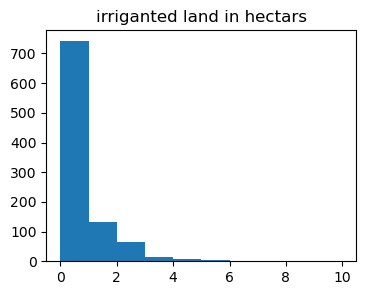

In [140]:
# visualise distributions
plt.figure(figsize=(4,3))
print(plt.hist(other_vars.irrigated_land))
plt.title("irriganted land in hectars")


In [141]:
# recode into binary variable as explained above
other_vars['irrigated_land_bin'] = np.where((other_vars['irrigated_land'].isna()) | (other_vars['irrigated_land'] == 0), 0 , 1)
print(other_vars[['irrigated_land', 'irrigated_land_bin']].head(10))
print(other_vars.irrigated_land_bin.value_counts())

   irrigated_land  irrigated_land_bin
0             2.0                   1
1             0.0                   0
2             NaN                   0
3             0.0                   0
4             2.0                   1
5             0.0                   0
6             NaN                   0
7             3.0                   1
8             0.0                   0
9             1.0                   1
irrigated_land_bin
0    2192
1     224
Name: count, dtype: int64


C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_61504\2835538576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_vars['irrigated_land_bin'] = np.where((other_vars['irrigated_land'].isna()) | (other_vars['irrigated_land'] == 0), 0 , 1)


# Merge topics and transform into long format

Separate topics are merged back together using the id variable.

In [153]:
# for each of the topics above, select the relevant (recoded), variables
age_vars2 = age_vars[['id','age_constant']]
children_vars2 = children_vars[['id', 'number_minors_r2', 'number_minors_r3', 'number_minors_r4', 'educ_child_recoded_r2', 'educ_child_recoded_r3','educ_child_recoded_r4', 
                                'educ_child_recodedNUMERIC_r2', 'educ_child_recodedNUMERIC_r3', 'educ_child_recodedNUMERIC_r4',
                                'activity_child_recoded_r2', 'activity_child_recoded_r3', 'activity_child_recoded_r4' ]]
educ_vars2 = educ_vars[['id', 'educ_recoded_constant', 'educ_recoded_constant_num']]
household_var2 = household_var
info_var2 = info_var[['id', 'main_info_source_recoded_r2', 'main_info_source_recoded_r3', 'main_info_source_recoded_r4']]
insurance_vars2 = insurance_vars[['id', 'purchase_bin_r2', 'know_vip_r2', 'trust_vip_r2', 'advise_vip_r2', 
                                        'purchase_bin_r3',  'know_vip_r3', 'trust_vip_r3', 'advise_vip_r3', 
                                        'purchase_bin_r4', 'know_vip_r4', 'trust_vip_r4', 'advise_vip_r4',
                                        'why_not_purchase_recoded_r2', 'why_not_purchase_recoded_r3', 'why_not_purchase_recoded_r4']]
move_vars2 = move_vars
phone_vars2 = phone_vars[['id', 'owns_phone_r2', 'owns_phone_r3', 'owns_phone_r4']]
religion_vars2 = religion_vars[['id', 'religion_recoded_r2', 'religion_recoded_r3', 'religion_recoded_r4']]

In [154]:
# merge all dataframe back together
dfs = [other_vars, children_vars2, educ_vars2, household_var2, info_var2, insurance_vars2, move_vars2, phone_vars2, religion_vars2, age_vars2] 

merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='id', how='outer')

merged_df

,id,expend,buy_goat_r4,buy_cattle_r4,buy_cattle_r3,buy_goat_r3,buy_cattle_r2,buy_goat_r2,buy_nr_cattle_r4,buy_nr_goat_r4,...,household_moved_r2,household_moved_r3,household_moved_r4,owns_phone_r2,owns_phone_r3,owns_phone_r4,religion_recoded_r2,religion_recoded_r3,religion_recoded_r4,age_constant
0,1,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,1,0,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,25.0
1,2,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,0,1,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,27.0
2,3,1.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,1,0,0,Christian,Christian,Christian,29.0
3,4,0.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,0,0,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,35.0
4,5,1.0,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,0,0,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,2412,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,1,1,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,46.0
2412,2413,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,1,0,0,Christian,Christian,Christian,45.0
2413,2414,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,No,No,0,0,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,38.0
2414,2415,NaN,Not buy,Not buy,Not buy,Not buy,Not buy,Not buy,0,0,...,No,Yes,No,1,1,0,Traditional/Wakefata,Traditional/Wakefata,Traditional/Wakefata,56.0


In [145]:
# overview of variables
for i in merged_df:
    print(i)

id
expend
buy_goat_r4
buy_cattle_r4
buy_cattle_r3
buy_goat_r3
buy_cattle_r2
buy_goat_r2
buy_nr_cattle_r4
buy_nr_goat_r4
buy_nr_cattle_r3
buy_nr_goat_r3
buy_nr_cattle_r2
buy_nr_goat_r2
irrigated_land
agric_land
eng_language
amh_language
afm_language
n_previd_cattle_r4
n_previd_cattle_r2
n_previd_cattle_r3
n_previd_goat_r2
n_previd_goat_r4
n_previd_goat_r3
cs_cs_diff_post_cattle_r4
cs_cs_ratio_post_cattle_r4
cs_cs_diff_post_goat_r4
cs_cs_ratio_post_goat_r4
cs_cs_diff_post_cattle_r3
cs_cs_ratio_post_cattle_r3
cs_cs_diff_post_goat_r3
cs_cs_ratio_post_goat_r3
cs_cs_diff_post_cattle_r2
cs_cs_ratio_post_cattle_r2
cs_cs_diff_post_goat_r2
cs_cs_ratio_post_goat_r2
irrigated_land_bin
number_minors_r2
number_minors_r3
number_minors_r4
educ_child_recoded_r2
educ_child_recoded_r3
educ_child_recoded_r4
educ_child_recodedNUMERIC_r2
educ_child_recodedNUMERIC_r3
educ_child_recodedNUMERIC_r4
activity_child_recoded_r2
activity_child_recoded_r3
activity_child_recoded_r4
educ_recoded_constant
educ_recoded_c

Datafram is transformed from wide to long format. Long format will be used for the ML models later on.

In [155]:
# Transform dataframe form wide format into long format (i.e., resulting df has one row per individual-wave)
df_long = pd.wide_to_long(
    merged_df,
    stubnames=["buy_cattle", "buy_goat", "buy_nr_cattle", "buy_nr_goat", "n_previd_cattle", "n_previd_goat",
               "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat",
               "number_minors", "educ_child_recoded", "educ_child_recodedNUMERIC", "activity_child_recoded", 
               "household_description", "number_adults", "main_info_source_recoded", 
               "religion_recoded", "owns_phone", "household_moved", "purchase_bin", "why_not_purchase_recoded", "know_vip", "trust_vip", "advise_vip"],
    i="id",
    j="wave",
    sep="_r"
).reset_index()

df_long

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,...,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip
0,1,4,No,25.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes
1,2,4,Yes,27.0,Yes,No,Adult Education,17,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
2,3,4,Yes,29.0,No,No,Elementary,6,No,1.0,...,2.0,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
3,4,4,No,35.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
4,5,4,No,36.0,Yes,No,Never attended,1,No,1.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,2412,2,NaN,46.0,NaN,NaN,Never attended,1,NaN,NaN,...,4.0,Interpersonal Sources,Traditional/Wakefata,1,No,No,Lack of Awareness or Understanding,Yes,Yes,No
7244,2413,2,NaN,45.0,NaN,NaN,Never attended,1,NaN,NaN,...,2.0,Professional and Organizational Sources,Christian,1,No,Yes,BOUGHT INSURANCE,Yes,Yes,No
7245,2414,2,NaN,38.0,NaN,NaN,Never attended,1,NaN,NaN,...,2.0,Professional and Organizational Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No
7246,2415,2,NaN,56.0,NaN,NaN,Never attended,1,NaN,NaN,...,2.0,Professional and Organizational Sources,Traditional/Wakefata,1,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,No


In [159]:
#merged_df.to_excel("Merged_df_wide_format_21_05.xlsx")

In [61]:
# This highlights some issues with the outcome variable, even though there a household has cattle, their outcome variable is missing. Samin is investigating.
test = df_long[df_long['cs_cs_diff_post_cattle']==0]
test[[ 'cs_cs_diff_post_cattle', 'cs_cs_ratio_post_cattle', 'buy_cattle', 'buy_nr_cattle', 'n_previd_cattle']].head(2)

,cs_cs_diff_post_cattle,cs_cs_ratio_post_cattle,buy_cattle,buy_nr_cattle,n_previd_cattle
33,0.0,NaN,Not buy,0,1
68,0.0,NaN,Not buy,0,7


# Handle Missing Values

First investigate how many values are missing per variable. We do this separately for independent and outcome variables.

In [160]:
print("Number of Missings in cs_cs_diff_post_cattle:", df_long.cs_cs_diff_post_cattle.isna().sum())
print("Number of Missings in cs_cs_ratio_post_cattle:", df_long.cs_cs_ratio_post_cattle.isna().sum())
print("Number of Missings in cs_cs_diff_post_goat:", df_long.cs_cs_diff_post_goat.isna().sum())
print("Number of Missings in cs_cs_ratio_post_goat:", df_long.cs_cs_ratio_post_goat.isna().sum())

Number of Missings in cs_cs_diff_post_cattle: 1420
Number of Missings in cs_cs_ratio_post_cattle: 3056
Number of Missings in cs_cs_diff_post_goat: 1116
Number of Missings in cs_cs_ratio_post_goat: 2787


In [161]:
# Print if there are missing and non-missing values in a variable
for column in df_long:
    number = df_long[column].isna().sum()
    if number > 0 and not column.startswith("cs") and not number==len(df_long):
        print(f"Number of Missings in {column}:", number)

# print if there are ONLY missing values in a variable
for column in df_long:
    number = df_long[column].isna().sum()
    if number==len(df_long):
        print(f"ONLY Missings in {column}:", number)

# print if there are NO missing values in a variable
for column in df_long:
    number = df_long[column].isna().sum()
    if number == 0:
        print(f"NO Missings in {column}:", number)

Number of Missings in afm_language: 21
Number of Missings in age_constant: 66
Number of Missings in agric_land: 21
Number of Missings in amh_language: 21
Number of Missings in eng_language: 21
Number of Missings in expend: 21
Number of Missings in irrigated_land: 4353
Number of Missings in educ_child_recoded: 197
Number of Missings in educ_child_recodedNUMERIC: 197
Number of Missings in activity_child_recoded: 197
Number of Missings in number_adults: 1
Number of Missings in main_info_source_recoded: 613
Number of Missings in religion_recoded: 15
Number of Missings in why_not_purchase_recoded: 8
NO Missings in id: 0
NO Missings in wave: 0
NO Missings in educ_recoded_constant: 0
NO Missings in educ_recoded_constant_num: 0
NO Missings in irrigated_land_bin: 0
NO Missings in buy_cattle: 0
NO Missings in buy_goat: 0
NO Missings in buy_nr_cattle: 0
NO Missings in buy_nr_goat: 0
NO Missings in n_previd_cattle: 0
NO Missings in n_previd_goat: 0
NO Missings in number_minors: 0
NO Missings in ho

Check pattern of missings for outcome variable depending on insurance purchase for exploratory purposes and to check for consistency in the data.

In [523]:
#not_miss_not_buy = df_long[(df_long['cs_cs_ratio_post_cattle'].notna()) & (df_long['buy_cattle']=='Not buy') & (df_long['cs_cs_ratio_post_cattle']>0.000) ][['id','wave', 'buy_cattle', 'cs_cs_ratio_post_cattle', 'cs_cs_diff_post_cattle']]
not_miss_not_buy = df_long[(df_long['cs_cs_ratio_post_goat'].notna()) & (df_long['buy_goat']=='Not buy') & (df_long['cs_cs_ratio_post_goat']>0.000) ][['id','wave', 'buy_cattle', 'cs_cs_ratio_post_goat', 'cs_cs_diff_post_goat']]
not_miss_not_buy

,id,wave,buy_cattle,cs_cs_ratio_post_goat,cs_cs_diff_post_goat


Result shows that NO household who did not buy the insurance made the right choice --> All respective household have 0 in the ratio outcome variable.

**Example below: Even tho household has goats, there are missings in y. WHY? Samin is investigating**

In [525]:
not_miss_not_buy = df_long[(df_long['cs_cs_diff_post_goat'].isna()) &  (df_long['n_previd_goat']>0) ][['id','wave', 'n_previd_goat', 'buy_goat', 'cs_cs_ratio_post_goat', 'cs_cs_diff_post_goat']]
not_miss_not_buy.head(2) # 

,id,wave,n_previd_goat,buy_goat,cs_cs_ratio_post_goat,cs_cs_diff_post_goat
646,647,4,4,Buy,NaN,NaN
658,659,4,4,Buy,NaN,NaN


# Handle Missings Using Forward-Fill

Missing values in the independet variables are handled using first forward-fill, then backward-fill for the remaining variables. This is a simple solution to missing data but given the panel nature and very short time in between waves, reasonable and justifiable.

In [162]:
for column in df_long:
    number = df_long[column].isna().sum()
    if number > 0 and not column.startswith("cs") and not number==len(df_long):
        print(f"Number of Missings in {column}:", number)

Number of Missings in afm_language: 21
Number of Missings in age_constant: 66
Number of Missings in agric_land: 21
Number of Missings in amh_language: 21
Number of Missings in eng_language: 21
Number of Missings in expend: 21
Number of Missings in irrigated_land: 4353
Number of Missings in educ_child_recoded: 197
Number of Missings in educ_child_recodedNUMERIC: 197
Number of Missings in activity_child_recoded: 197
Number of Missings in number_adults: 1
Number of Missings in main_info_source_recoded: 613
Number of Missings in religion_recoded: 15
Number of Missings in why_not_purchase_recoded: 8


In [163]:
df_filled = df_long
df_filled['afm_language'] = df_filled.groupby('id')['afm_language'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['age_constant'] = df_filled.groupby('id')['age_constant'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['agric_land'] = df_filled.groupby('id')['agric_land'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['amh_language'] = df_filled.groupby('id')['amh_language'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['eng_language'] = df_filled.groupby('id')['eng_language'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['expend'] = df_filled.groupby('id')['expend'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['educ_child_recoded'] = df_filled.groupby('id')['educ_child_recoded'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['activity_child_recoded'] = df_filled.groupby('id')['activity_child_recoded'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['number_adults'] = df_filled.groupby('id')['number_adults'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['main_info_source_recoded'] = df_filled.groupby('id')['main_info_source_recoded'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['religion_recoded'] = df_filled.groupby('id')['religion_recoded'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['why_not_purchase_recoded'] = df_filled.groupby('id')['why_not_purchase_recoded'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
df_filled['educ_child_recodedNUMERIC'] = df_filled.groupby('id')['educ_child_recodedNUMERIC'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))

for column in df_filled:
    number = df_filled[column].isna().sum()
    if number > 0 and not column.startswith("cs") and not number==len(df_filled):
        print(f"Number of Missings in {column}:", number)

C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_61504\2067710165.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled['afm_language'] = df_filled.groupby('id')['afm_language'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_61504\2067710165.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled['agric_land'] = df_filled.groupby('id')['agric_land'].transform(lambda x: x.ffill().bfill().infer_objects(copy=False))
C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_61504\2

Number of Missings in afm_language: 21
Number of Missings in age_constant: 66
Number of Missings in agric_land: 21
Number of Missings in amh_language: 21
Number of Missings in eng_language: 21
Number of Missings in expend: 21
Number of Missings in irrigated_land: 4353
Number of Missings in educ_child_recoded: 3
Number of Missings in educ_child_recodedNUMERIC: 3
Number of Missings in activity_child_recoded: 3
Number of Missings in religion_recoded: 15


In [164]:
#df_filled.to_excel("df_filled_for_exploratoy_analyses_21_05.xlsx")

# Create Dataframe for Goat Models

We create a goat dataset by removing redundant columns (irrigated_land and any variable related to cattle), filtering for missing data on the outcome variable, and finally filtering for the remaining missing values on the independent variables. The analysis shows that using listwise deletion for the independent variables results in a loss of 31 households, equating to around 1.4% of all households. This small number justifies the use of listwise deletion. More sophisticated methods for missing data imputation would require additional assumptions, which might be difficult to adhere to and could create problems with the range of models we are conducting later on.

In [165]:
goat_df = df_filled[df_filled['cs_cs_diff_post_goat'].notna() & df_filled['cs_cs_ratio_post_goat'].notna()]
goat_df = goat_df.drop(columns=['irrigated_land', 'buy_nr_cattle', 'n_previd_cattle','buy_cattle', 'cs_cs_diff_post_cattle', 'cs_cs_ratio_post_cattle'])
goat_df.head()

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,...,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip
0,1,4,No,25.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes
1,2,4,Yes,27.0,Yes,No,Adult Education,17,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
2,3,4,Yes,29.0,No,No,Elementary,6,No,1.0,...,2.0,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
3,4,4,No,35.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
4,5,4,No,36.0,Yes,No,Never attended,1,No,1.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes


In [166]:
for column in goat_df:
    number = goat_df[column].isna().sum()
    if number > 0 and not column.startswith("cs") and not number==len(goat_df):
        print(f"Number of Missings in {column}:", number)

Number of Missings in afm_language: 11
Number of Missings in age_constant: 38
Number of Missings in agric_land: 11
Number of Missings in amh_language: 11
Number of Missings in eng_language: 11
Number of Missings in expend: 11
Number of Missings in educ_child_recoded: 3
Number of Missings in educ_child_recodedNUMERIC: 3
Number of Missings in activity_child_recoded: 3
Number of Missings in religion_recoded: 6


Remove rows with missing values on any of the listed variables.

In [167]:
goat_df_final = goat_df[goat_df[['afm_language', 'age_constant', 'agric_land', 'amh_language', 'eng_language', 'expend', 'educ_child_recoded', 'educ_child_recodedNUMERIC', 'activity_child_recoded', 'religion_recoded']].notna().all(axis=1)]

Check how many individuals are lost due to filtering.

In [168]:
num_individuals_before_filtering = goat_df['id'].nunique()
num_individuals_after_filtering = goat_df_final['id'].nunique()

print("num_individuals_before_filtering:", num_individuals_before_filtering)
print("num_individuals_after_filtering:", num_individuals_after_filtering)
print("Difference / Number of individuals we would lose:", num_individuals_before_filtering-num_individuals_after_filtering)

num_individuals_before_filtering: 2266
num_individuals_after_filtering: 2235
Difference / Number of individuals we would lose: 31


Check how many rows are lost due to filtering.

In [169]:
num_rows_before_filtering = len(goat_df)
num_rows_after_filtering = len(goat_df_final)

print("num_individuals_before_filtering:", num_rows_before_filtering)
print("num_individuals_after_filtering:", num_rows_after_filtering)
print("Difference / Number of individual-waves (aka. rows) we would lose:", num_rows_before_filtering-num_rows_after_filtering)
print("Percentage of removed rows:", round((1 - (num_rows_after_filtering / num_rows_before_filtering))*100,2), "%")

num_individuals_before_filtering: 4461
num_individuals_after_filtering: 4403
Difference / Number of individual-waves (aka. rows) we would lose: 58
Percentage of removed rows: 1.3 %


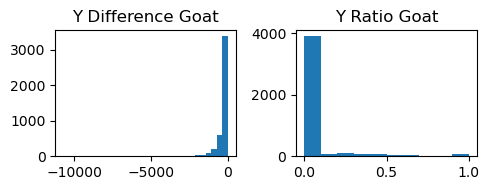

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))

axes[0].hist(goat_df_final.cs_cs_diff_post_goat, bins=30, range=[goat_df_final.cs_cs_diff_post_goat.min(), goat_df_final.cs_cs_diff_post_goat.max()])
axes[0].set_title("Y Difference Goat")

axes[1].hist(goat_df_final.cs_cs_ratio_post_goat, bins=10, range=[0, 1])
axes[1].set_title("Y Ratio Goat")
plt.tight_layout()

# Create Dataframe for Cattle Models

We create a cattle dataset by removing redundant columns (irrigated_land and any variable related to goat), filtering for missing data on the outcome variable, and finally filtering for the remaining missing values on the independent variables. The analysis shows that using listwise deletion for the independent variables results in a loss of 31 households, equating to around 1.4% of all households. This small number justifies the use of listwise deletion. More sophisticated methods for missing data imputation would require additional assumptions, which might be difficult to adhere to and could create problems with the range of models we are conducting later on.

In [171]:
cattle_df = df_filled[df_filled['cs_cs_diff_post_cattle'].notna() & df_filled['cs_cs_ratio_post_cattle'].notna()]
cattle_df = cattle_df.drop(columns=['irrigated_land', 'buy_nr_goat', 'n_previd_goat','buy_goat', 'cs_cs_diff_post_goat', 'cs_cs_ratio_post_goat'])
cattle_df.head()

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,...,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip
0,1,4,No,25.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes
1,2,4,Yes,27.0,Yes,No,Adult Education,17,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
2,3,4,Yes,29.0,No,No,Elementary,6,No,1.0,...,2.0,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
3,4,4,No,35.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
5,6,4,No,60.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No


In [172]:
for column in cattle_df:
    number = cattle_df[column].isna().sum()
    if number > 0 and not column.startswith("cs"):
        print(f"Number of Missings in {column}:", number)

Number of Missings in afm_language: 8
Number of Missings in age_constant: 33
Number of Missings in agric_land: 8
Number of Missings in amh_language: 8
Number of Missings in eng_language: 8
Number of Missings in expend: 8
Number of Missings in educ_child_recoded: 3
Number of Missings in educ_child_recodedNUMERIC: 3
Number of Missings in activity_child_recoded: 3
Number of Missings in religion_recoded: 6


Remove rows with missing values on any of the listed variables.

In [173]:
cattle_df_final = cattle_df[cattle_df[['afm_language', 'age_constant', 'agric_land', 'amh_language', 'eng_language', 'expend', 'educ_child_recoded', 'educ_child_recodedNUMERIC', 'activity_child_recoded', 'religion_recoded']].notna().all(axis=1)]
cattle_df_final.head()

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,...,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip
0,1,4,No,25.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes
1,2,4,Yes,27.0,Yes,No,Adult Education,17,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
2,3,4,Yes,29.0,No,No,Elementary,6,No,1.0,...,2.0,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
3,4,4,No,35.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes
5,6,4,No,60.0,Yes,No,Never attended,1,No,0.0,...,2.0,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No


Check how many individuals are lost due to filtering.

In [174]:
num_individuals_before_filtering = cattle_df['id'].nunique()
num_individuals_after_filtering = cattle_df_final['id'].nunique()

print("num_individuals_before_filtering:", num_individuals_before_filtering)
print("num_individuals_after_filtering:", num_individuals_after_filtering)
print("Difference / Number of individuals we would lose:", num_individuals_before_filtering-num_individuals_after_filtering)

num_individuals_before_filtering: 2219
num_individuals_after_filtering: 2189
Difference / Number of individuals we would lose: 30


Check how many rows are lost due to filtering.

In [175]:
num_rows_before_filtering = len(cattle_df)
num_rows_after_filtering = len(cattle_df_final)

print("num_individuals_before_filtering:", num_rows_before_filtering)
print("num_individuals_after_filtering:", num_rows_after_filtering)
print("Difference / Number of individual-waves (aka. rows) we would lose:", num_rows_before_filtering-num_rows_after_filtering)
print("Percentage of removed rows:", round((1 - (num_rows_after_filtering / num_rows_before_filtering))*100,2), "%")

num_individuals_before_filtering: 4192
num_individuals_after_filtering: 4142
Difference / Number of individual-waves (aka. rows) we would lose: 50
Percentage of removed rows: 1.19 %


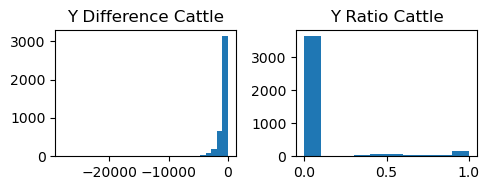

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,2))

axes[0].hist(cattle_df_final.cs_cs_diff_post_cattle, bins=30, range=[cattle_df_final.cs_cs_diff_post_cattle.min(), cattle_df_final.cs_cs_diff_post_cattle.max()]) #
axes[0].set_title("Y Difference Cattle")

axes[1].hist(cattle_df_final.cs_cs_ratio_post_cattle, bins=10, range=[0, 1])
axes[1].set_title("Y Ratio Cattle")
plt.tight_layout()

## Exploratory Correlation Matrix for numeric variables

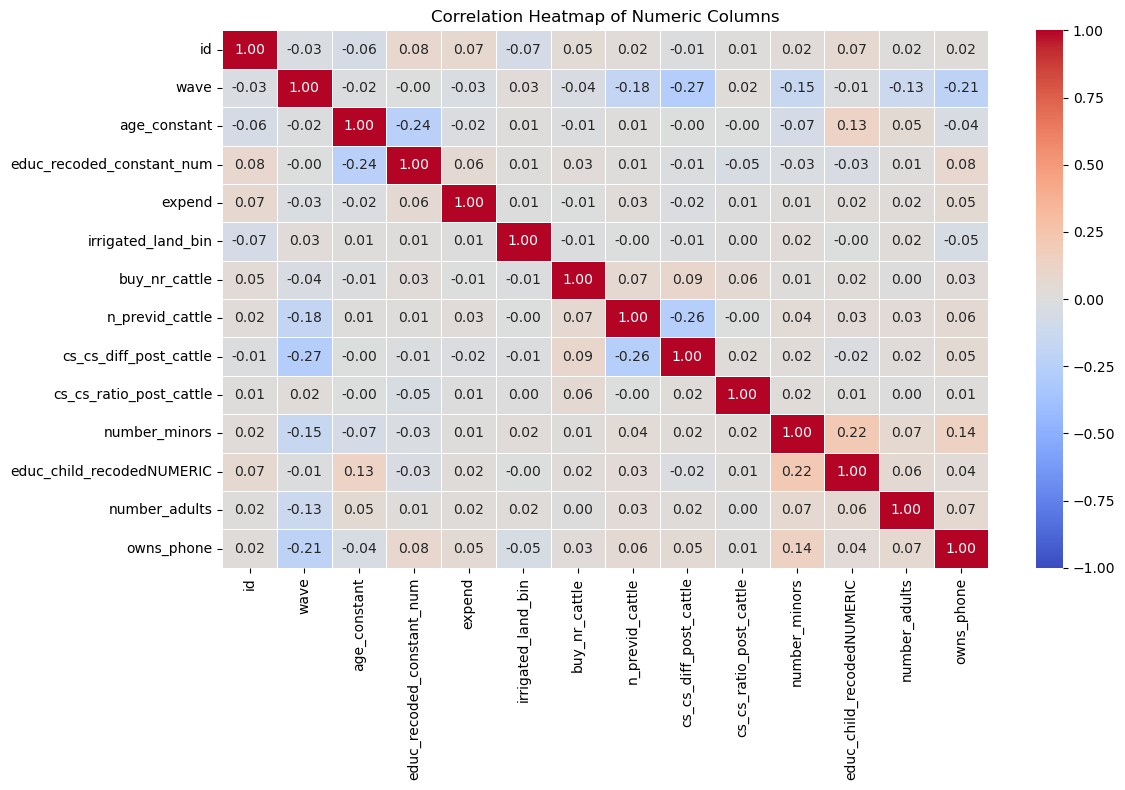

In [177]:
# Select numeric columns and compute correlations
numeric_cols = cattle_df_final.select_dtypes(include='number')
corr_matrix = numeric_cols.corr()

# Plot with diverging colormap and fixed scale
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',   # diverging colormap
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1
)
plt.title("Correlation Heatmap of Numeric Columns")
plt.tight_layout()
plt.show()

# Investigate Outcome Transformations

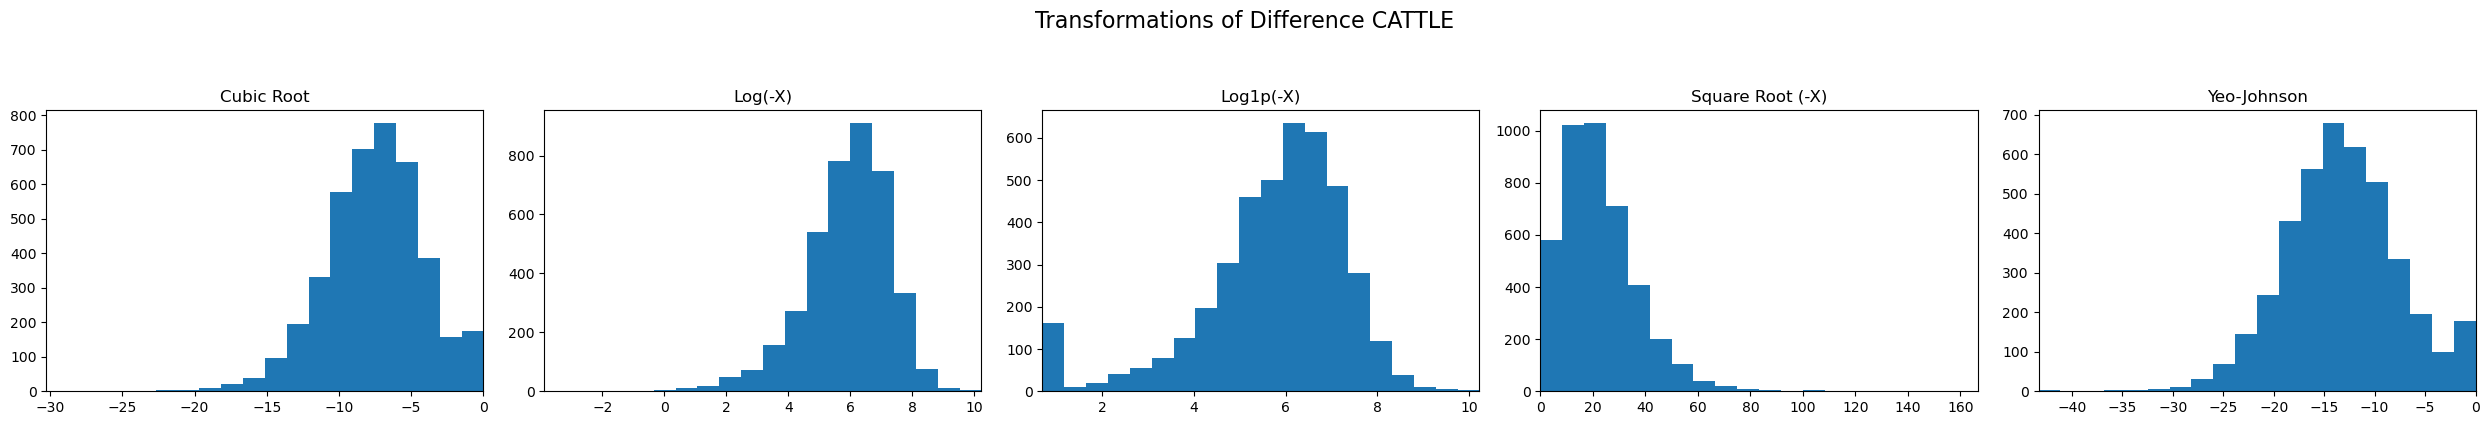

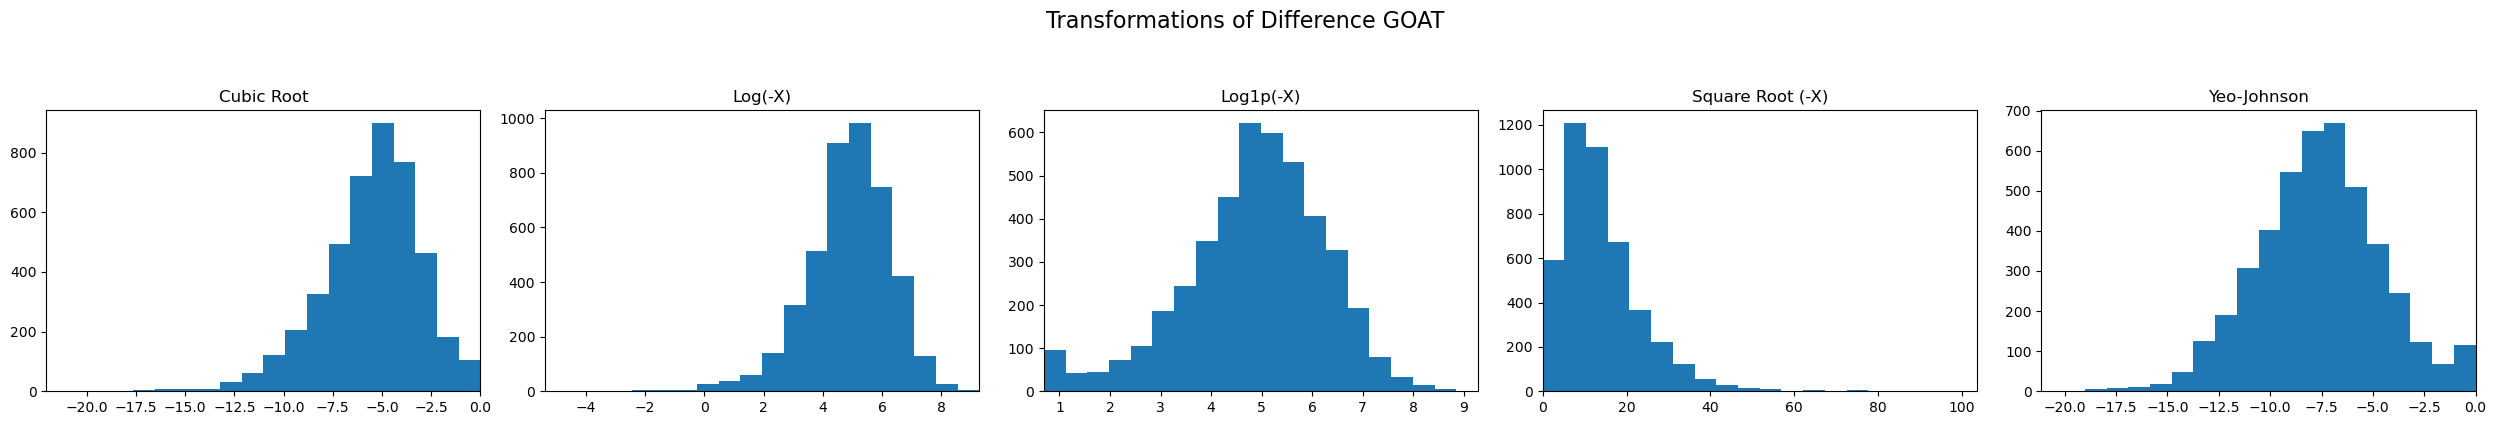

c:\anaconda_custom\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\anaconda_custom\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


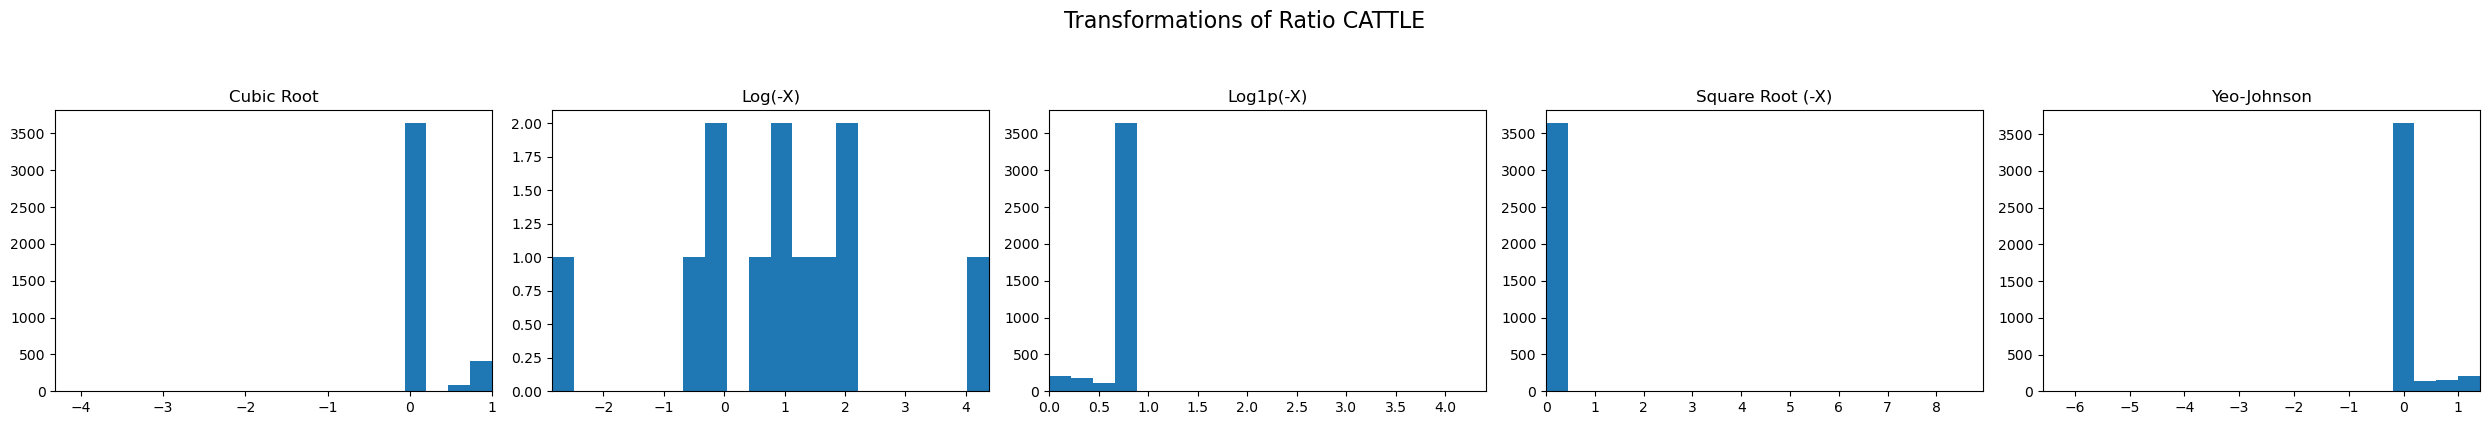

C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_61504\475017779.py:34: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(transformed.min(), transformed.max())


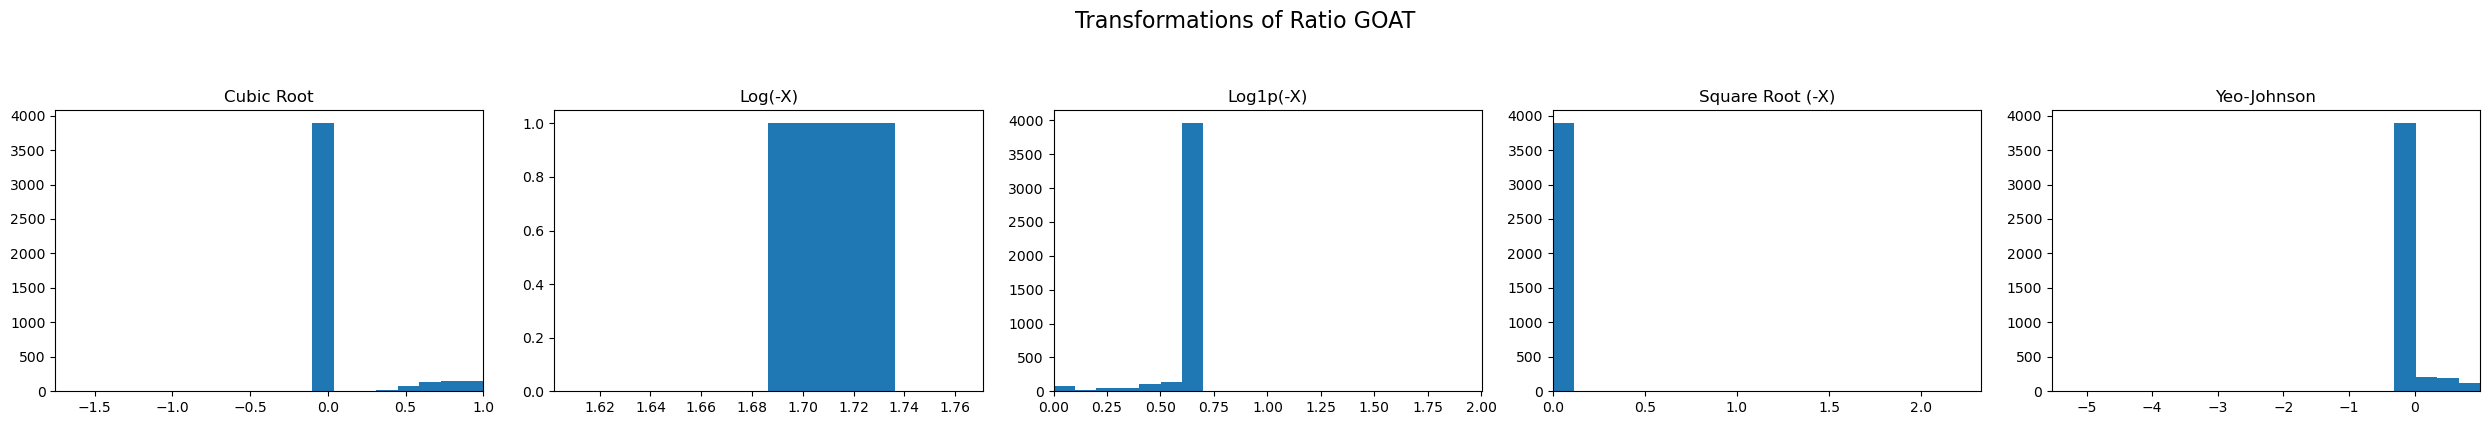

In [179]:
def plot_transformations(y, title_prefix="OUTCOME"):
    """
    Apply and plot several transformations of the input variable y.

    Args:
        y (pd.Series or np.array): The variable to transform and plot.
        title_prefix (str): Prefix for printed and plot titles.
    """
    # Define transformations to try
    transformations = {
        'Cubic Root': lambda x: np.cbrt(x),
        'Log(-X)': lambda x: np.log(-x), # np.log1p(-x+1)
        'Log1p(-X)': lambda x: np.log1p(-x+1), # np.log1p(-x+1)
        'Square Root (-X)': lambda x: np.sqrt(-x),
        'Yeo-Johnson': lambda x: stats.yeojohnson(x.dropna())[0]
    }

    fig, axes = plt.subplots(nrows=1, ncols=len(transformations), figsize=(5 * len(transformations), 4))

    # Add the overall title
    fig.suptitle(f"Transformations of {title_prefix}", fontsize=16, y=1.05)

    for ax, (name, func) in zip(axes, transformations.items()):
        try:
            transformed = func(y)

            # Drop NaNs and infs just in case - makes code more stable
            transformed = transformed[np.isfinite(transformed)]

            ax.hist(transformed, bins=20)
            ax.set_title(name)

            # Automatically adjust x-axis based on the transformed data
            ax.set_xlim(transformed.min(), transformed.max())

        except Exception as e:
            ax.set_title(f"{name}\n(Failed)")
            ax.axis('off')  # Hide the plot if transformation fails

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)  # Make space for the overall title
    plt.show()

plot_transformations(cattle_df_final.cs_cs_diff_post_cattle, title_prefix="Difference CATTLE")
plot_transformations(goat_df_final.cs_cs_diff_post_goat, title_prefix="Difference GOAT")
plot_transformations(cattle_df_final.cs_cs_ratio_post_cattle, title_prefix="Ratio CATTLE")
plot_transformations(goat_df_final.cs_cs_ratio_post_goat, title_prefix="Ratio GOAT")

Log+1 transformation of the difference variable looks good.

Not sure how or whether to proceed with the ratio variable.

# Save Cattle and Goat dfs

In [180]:
cattle_df_final.to_excel("cattle_df_final2105.xlsx")
goat_df_final.to_excel("goat_df_final2105.xlsx")

## Investigations into the Ratio Variable and its Problems

In [181]:
print(cattle_df_final.cs_cs_ratio_post_cattle.min())
print(cattle_df_final.cs_cs_ratio_post_cattle.max())

-80.24618530273438
1.0


In [182]:
print(goat_df_final.cs_cs_ratio_post_goat.min())
print(goat_df_final.cs_cs_ratio_post_goat.max())

-5.400449275970459
1.0


In [94]:
test = goat_df_final[goat_df_final['cs_cs_ratio_post_goat']<0]
test[['id', 'wave', 'cs_cs_ratio_post_goat', 'cs_cs_diff_post_goat', 'n_previd_goat', 'buy_nr_goat']]

,id,wave,cs_cs_ratio_post_goat,cs_cs_diff_post_goat,n_previd_goat,buy_nr_goat
6308,1477,2,-5.400449,-22.681162,15,5


In [97]:
test = cattle_df_final[cattle_df_final['cs_cs_ratio_post_cattle']<0]
test[['id', 'wave', 'cs_cs_ratio_post_cattle', 'cs_cs_diff_post_cattle', 'n_previd_cattle', 'buy_nr_cattle']]

,id,wave,cs_cs_ratio_post_cattle,cs_cs_diff_post_cattle,n_previd_cattle,buy_nr_cattle
2730,315,3,-5.387077,-260.970825,10,3
2854,439,3,-2.176626,-147.360886,7,4
2966,551,3,-0.058015,-28.735567,3,1
3022,607,3,-2.120883,-145.489716,5,4
4300,1885,3,-3.301458,-224.824570,4,4
4304,1889,3,-8.067451,-679.248413,9,8
5462,631,2,-2.203892,-22.267967,5,3
5881,1050,2,-80.246185,-481.019318,7,4
6071,1240,2,-7.774558,-649.535522,12,3
6149,1318,2,-0.934803,-56.528103,4,2


In [104]:
test = df[df['cs_cs_ratio_post_cattle_r4']<0]
test[['id', 'cs_cs_diff_post_cattle_r4', 'cs_cs_ratio_post_cattle_r4']]

,id,cs_cs_diff_post_cattle_r4,cs_cs_ratio_post_cattle_r4


Text(0.5, 1.0, 'Distribution of Welfare Difference Outcome - Cattle Dataset')

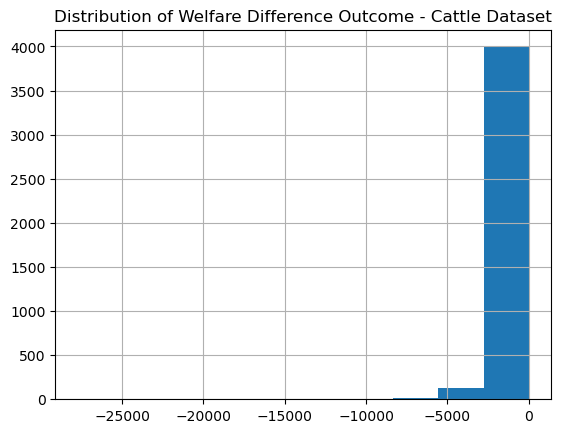

In [13]:
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/')

df = pd.read_excel("cattle_df_final2105.xlsx")

df.cs_cs_diff_post_cattle.hist()
plt.title("Distribution of Welfare Difference Outcome - Cattle Dataset")

Text(0.5, 1.0, 'Distribution of Welfare Difference Outcome - Goat Dataset')

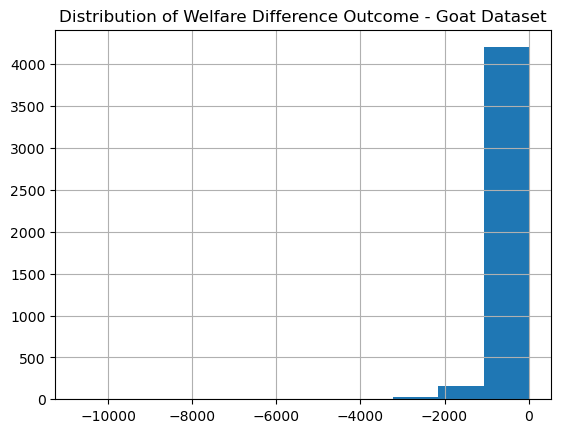

In [14]:
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/')

df = pd.read_excel("goat_df_final2105.xlsx")

df.cs_cs_diff_post_goat.hist()
plt.title("Distribution of Welfare Difference Outcome - Goat Dataset")